In [1]:
# General libraries
import os
import re
import random
import statistics
import collections
from collections import Counter

# Data handling
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm, colors, colorbar
from sklearn.manifold import TSNE
from matplotlib_venn import venn2

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
mmscaler = MinMaxScaler()

# Feature selection
from sklearn.feature_selection import SelectFromModel
from boruta import BorutaPy

# Decomposition
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver='full')

# Dimensionality reduction
from pyts.utils import windowed_view

# Statistical tests and models
import statsmodels.api as sm
from scipy.stats import (ttest_ind, levene, mannwhitneyu, shapiro, mstats)
from statannot import add_stat_annotation
from statsmodels.stats.multitest import multipletests

# Machine learning models
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN

# Classifiers
rdg = RidgeClassifier(alpha=0.5)
mlp = MLPClassifier(random_state=1, max_iter=300, activation='relu')
lgr = LogisticRegression(random_state=1, max_iter=500)
DT = DecisionTreeClassifier(random_state=0, max_depth=10)
adb = AdaBoostClassifier(n_estimators=100, random_state=0)
gbc = GradientBoostingClassifier(n_estimators=100, random_state=1)
knn = KNeighborsClassifier(n_neighbors=3)
SGD = SGDClassifier(loss='log', random_state=1, max_iter=100, early_stopping=True,
                    learning_rate='optimal', validation_fraction=0.2)
rf = RandomForestClassifier(max_depth=10, random_state=0)
clf_svm = SVC(kernel='rbf')

# Model evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# Model selection and validation
from sklearn.model_selection import (
    train_test_split, LeaveOneOut, StratifiedKFold, GridSearchCV, cross_val_score
)

# Shapelet learning
from pyts.classification import LearningShapelets
from pyts.datasets import load_gunpoint

# Geometry
from scipy.spatial import ConvexHull, convex_hull_plot_2d

# Progress bar
from tqdm import tqdm

# Others
import umap
from sklearn.metrics import pairwise_distances
from scipy.stats import ttest_ind
from mpl_toolkits.axes_grid1 import make_axes_locatable
from adjustText import adjust_text

In [2]:
OB_BL=pd.read_csv('/home/jupy/miRNA/Acute_WL/Rajesh_miRNA_data/OB_BL_MIRNA.csv')
df_OB_BL=OB_BL.T

OB_PWL=pd.read_csv('/home/jupy/miRNA/Acute_WL/Rajesh_miRNA_data/OB_PWL_MIRNA.csv')
df_OB_PWL=OB_PWL.T

LEAN=pd.read_csv('/home/jupy/miRNA/Acute_WL/Rajesh_miRNA_data/LEAN_MIRNA.csv')
df_LEAN=LEAN.T

In [7]:
def create_data(df):
    # Subject IDs are in the row index, we create a list
    subject_id_ls = df.index.tolist()[2:]    
    # Extract feature names using the row index "Unmaed: 1"
    feature_id_ls=df.loc[['Unnamed: 1']].values.flatten().tolist()
    # Etract numerical values as the miRNA value, in shape (12 subjects * 828 features)
    feature_array=df.values[2:,:]
    print("Subject IDs:", len(subject_id_ls))
    print("Feature Names:", len(feature_id_ls))
    print("miRNA Values:", feature_array.shape)

    print("Subject IDs:", (subject_id_ls))
    print("Feature Names:", (feature_id_ls))
    print("miRNA Values:", feature_array)
    print('-----------------------------------------------')
    return subject_id_ls, feature_id_ls, feature_array

**nSolver** used for normalization

In [22]:
subject_id_ls={}
feature_id_ls={}
feature_array={}
for df, class_name in zip([df_OB_BL,df_OB_PWL,df_LEAN],['OB_BL','OB_PWL','LEAN']):
    subject_id_ls[class_name]=create_data(df)[0]
    feature_id_ls[class_name]=create_data(df)[1]
    feature_array[class_name]=create_data(df)[2]
    ### |Log2| transform
    feature_array[class_name]=np.abs(np.log2( np.array( feature_array[class_name], dtype=float) ))

Subject IDs: 12
Feature Names: 828
miRNA Values: (12, 828)
Subject IDs: ['F048-obese before', 'F111-obese before', 'F248-obese before', 'F030-obese before', 'F197-obese before', 'F078-obese before', 'F233-obese before', 'F047-obese before', 'F170', 'F069', 'F091', 'F045']
Feature Names: ['hsa-let-7a-5p', 'hsa-let-7b-5p', 'hsa-let-7c-5p', 'hsa-let-7d-5p', 'hsa-let-7e-5p', 'hsa-let-7f-5p', 'hsa-let-7g-5p', 'hsa-let-7i-5p', 'hsa-miR-1-3p', 'hsa-miR-1-5p', 'hsa-miR-100-5p', 'hsa-miR-101-3p', 'hsa-miR-103a-3p', 'hsa-miR-105-5p', 'hsa-miR-106a-5p+hsa-miR-17-5p', 'hsa-miR-106b-5p', 'hsa-miR-107', 'hsa-miR-10a-5p', 'hsa-miR-10b-5p', 'hsa-miR-1178-3p', 'hsa-miR-1180-3p', 'hsa-miR-1183', 'hsa-miR-1185-1-3p', 'hsa-miR-1185-2-3p', 'hsa-miR-1185-5p', 'hsa-miR-1193', 'hsa-miR-1197', 'hsa-miR-1200', 'hsa-miR-1202', 'hsa-miR-1203', 'hsa-miR-1204', 'hsa-miR-1205', 'hsa-miR-1206', 'hsa-miR-122-5p', 'hsa-miR-1224-3p', 'hsa-miR-1224-5p', 'hsa-miR-1226-3p', 'hsa-miR-1228-3p', 'hsa-miR-1233-3p', 'hsa-miR-12

#### Feature Selection and Classification 

In [23]:
def dli_wfs(X, y, D=10, M=10, random_state=42):
    """
    Modified DLI-WFS with performance-validated feature removal
    
    Parameters:
    - X: Feature matrix (n_samples, n_features)
    - y: Target vector (n_samples,)
    - D: Target number of selected features (default=10)
    - M: Maximal allowed dip runs (default=10)
    - random_state: Random seed for reproducibility
    
    Returns:
    - selected_features: Indices of selected features (sorted by importance)
    - accuracy_trace: List of validation accuracies during feature selection process
    - num_features_trace: Corresponding number of features at each step
    """
    # Initialize Random Forest for feature importance
    rf = RandomForestClassifier(random_state=random_state)
    rf.fit(X, y)
    
    # Get features sorted by importance (descending)
    importance_scores = rf.feature_importances_
    sorted_features = np.argsort(importance_scores)[::-1]
    
    # Initialize variables
    F_s = [sorted_features[0]]  # Start with top feature
    cruns = 0
    j = 1
    n_features = len(sorted_features)
    
    # For tracking performance during selection
    accuracy_trace = []
    num_features_trace = []
    removal_decisions = []  # Track removal decisions
    
    # Inner CV for evaluation (5-fold stratified)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
    while j < n_features:
        # Evaluate current feature set performance (a_o)
        current_rf = RandomForestClassifier(random_state=random_state)
        scores = cross_val_score(current_rf, X[:, F_s], y, cv=inner_cv, scoring='accuracy')
        a_o = np.mean(scores)
        
        # Add next feature
        F_s.append(sorted_features[j])
        
        # Evaluate new performance (a_n)
        current_rf = RandomForestClassifier(random_state=random_state)
        scores = cross_val_score(current_rf, X[:, F_s], y, cv=inner_cv, scoring='accuracy')
        a_n = np.mean(scores)
        
        # Record performance before any removal
        accuracy_trace.append(a_n)
        num_features_trace.append(len(F_s))
        
        if a_n - a_o > 0.1:
            cruns = 0  # Reset dip counter if performance improved
        else:
            cruns += 1  # Increment dip counter
            
            # Store original state before removal attempt
            original_features = F_s.copy()
            original_acc = a_n
            
            # Compute feature importance on current subset
            subset_rf = RandomForestClassifier(random_state=random_state)
            subset_rf.fit(X[:, F_s], y)
            U = subset_rf.feature_importances_
            
            # Find least important feature
            f_bad = F_s[np.argmin(U)]
            
            # Tentatively remove the feature
            F_s.remove(f_bad)
            
            # Evaluate performance after removal
            current_rf = RandomForestClassifier(random_state=random_state)
            scores = cross_val_score(current_rf, X[:, F_s], y, cv=inner_cv, scoring='accuracy')
            a_after_removal = np.mean(scores)
            
            # Performance validation check
            if a_after_removal > original_acc:
                # Keep the removal - it improved performance
                removal_decisions.append(f"Removed {f_bad} - Improved accuracy from {original_acc:.4f} to {a_after_removal:.4f}")
                # Update the last accuracy point
                accuracy_trace[-1] = a_after_removal
                num_features_trace[-1] = len(F_s)
            else:
                # Revert the removal - it didn't help
                F_s = original_features
                removal_decisions.append(f"Retained {f_bad} - Removal would decrease accuracy from {original_acc:.4f} to {a_after_removal:.4f}")
                # Keep the original accuracy measurement
                accuracy_trace[-1] = original_acc
                num_features_trace[-1] = len(F_s)
        
        # Check stopping conditions
        if cruns == M or len(F_s) >= D:
            break
            
        j += 1
    
    # Print removal decisions for debugging
    print("\nFeature Removal Decisions:")
    for decision in removal_decisions:
        print(decision)
    
    return np.array(F_s), accuracy_trace, num_features_trace

In [24]:
# ====================== Evaluation Metrics ======================
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def sensitivity_score(y_true, y_pred):
    return recall_score(y_true, y_pred)  # Sensitivity is the same as recall

def evaluate_with_multiple_seeds(X_train, y_train, X_test, y_test, feature_indices, n_seeds=100):
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'specificity': [],
        'sensitivity': [],
        'auc': []
    }
    
    for seed in range(n_seeds):
        # Use only the selected features
        X_train_sub = X_train[:, feature_indices]
        X_test_sub = X_test[:, feature_indices]
        
        # Train and predict with current seed
        rf = RandomForestClassifier(random_state=seed)
        rf.fit(X_train_sub, y_train)
        
        # For AUC we need probability predictions
        if len(np.unique(y_test)) > 1:  # Check if we have both classes in test set
            y_probs = rf.predict_proba(X_test_sub)[:, 1]
            auc = roc_auc_score(y_test, y_probs)
        else:
            auc = np.nan
        
        y_pred = rf.predict(X_test_sub)
        
        # Store all metrics
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred, zero_division=0))
        metrics['recall'].append(recall_score(y_test, y_pred, zero_division=0))
        metrics['f1'].append(f1_score(y_test, y_pred, zero_division=0))
        metrics['specificity'].append(specificity_score(y_test, y_pred))
        metrics['sensitivity'].append(sensitivity_score(y_test, y_pred))
        metrics['auc'].append(auc)
    
    # Return average metrics
    return {k: np.nanmean(v) for k, v in metrics.items()}

In [25]:
# ====================== Main Experiment Function ======================
def run_experiment_with_dliwfs(X, y, D=10, M=10, top_k=5, n_seeds=3, random_state=42):
    # Initialize results storage
    results = {
        'fold_test_metrics': [],
        'selected_features': [],
        'plots': []
    }
    
    # Outer 10-fold stratified CV
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    
    for fold, (train_idx, test_idx) in enumerate(tqdm(cv.split(X, y), total=10)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Run DLI-WFS feature selection
        selected_features, acc_trace, num_feat_trace = dli_wfs(
            X_train, y_train, D=D, M=M, random_state=random_state
        )
        
        # Store selected features (indices)
        results['selected_features'].append(selected_features)
        
        # Get top k features
        top_features = selected_features[:top_k]
        
        # Evaluate with multiple seeds
        fold_metrics = evaluate_with_multiple_seeds(
            X_train, y_train, X_test, y_test, top_features, n_seeds=n_seeds
        )
        results['fold_test_metrics'].append(fold_metrics)
        
        # Create plot for this fold
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(num_feat_trace, acc_trace, 'o-')
        ax.set_xlabel('Number of Selected Features')
        ax.set_ylabel('Validation Accuracy')
        ax.set_title(f'Fold {fold+1}: Feature Selection Process\n'
                    f'Top {top_k} features used for testing')
        ax.grid(True)
        results['plots'].append(fig)
        
        # Print fold summary
        print(f"\nFold {fold+1} completed:")
        print(f"Selected features (indices): {selected_features}")
        print(f"Top {top_k} features used: {top_features}")
        print("Test metrics (averaged over 100 seeds):")
        for metric, value in fold_metrics.items():
            print(f"{metric:12s}: {value:.4f}")
    
    # Calculate average metrics across all folds
    avg_metrics = {
        metric: np.mean([fold[metric] for fold in results['fold_test_metrics']])
        for metric in results['fold_test_metrics'][0].keys()
    }
    
    print("\n=== Final Average Metrics ===")
    for metric, value in avg_metrics.items():
        print(f"{metric:12s}: {value:.4f}")
    
    return results


In [26]:
def run_experiment_with_boruta(X, y, top_k=5, n_seeds=3, random_state=42):
    """
    Main experiment function using Boruta for feature selection
    
    Parameters:
    - X: Feature matrix (n_samples, n_features)
    - y: Target vector (n_samples,)
    - top_k: Number of top features to select and use for final evaluation
    - n_seeds: Number of random seeds for evaluation
    - random_state: Random seed for reproducibility
    
    Returns:
    - Dictionary containing results similar to original experiment
    """
    # Initialize results storage
    results = {
        'fold_test_metrics': [],
        'selected_features': [],
        'plots': []
    }
    
    # Outer 10-fold stratified CV
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    
    for fold, (train_idx, test_idx) in enumerate(tqdm(cv.split(X, y), total=10)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Initialize Random Forest and Boruta
        rf = RandomForestClassifier(n_jobs=-1, random_state=random_state)
        boruta_selector = BorutaPy(
            estimator=rf,
            n_estimators='auto',
            verbose=0,
            random_state=random_state,
            alpha=0.05,
            max_iter=100,
            perc=100)  # Setting perc=100 makes Boruta more conservative
        
        # Run Boruta feature selection
        boruta_selector.fit(X_train, y_train)
        
        # Get importance scores from Boruta
        feature_importances = boruta_selector.ranking_
        
        # Select top_k features with lowest Boruta ranks (1 is best)
        selected_features = np.argsort(feature_importances)[:top_k]
        
        # Store selected features
        results['selected_features'].append(selected_features)
        
        # Get importance scores for selected features by training a new RF
        rf_selected = RandomForestClassifier(random_state=random_state)
        rf_selected.fit(X_train[:, selected_features], y_train)
        importances = rf_selected.feature_importances_
        
        # Sort the selected features by their importance
        top_features = selected_features[np.argsort(importances)[::-1]]
        
        # Evaluate with multiple seeds
        fold_metrics = evaluate_with_multiple_seeds(
            X_train, y_train, X_test, y_test, top_features, n_seeds=n_seeds
        )
        results['fold_test_metrics'].append(fold_metrics)
        
        # Create plot
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(range(len(importances)), importances)
        ax.set_xlabel('Feature Index (in selected features)')
        ax.set_ylabel('Importance Score')
        ax.set_title(f'Fold {fold+1}: Feature Importances\n'
                    f'Top {top_k} features used for testing')
        ax.set_xticks(range(len(selected_features)))
        ax.set_xticklabels(selected_features)
        ax.grid(True)
        results['plots'].append(fig)
        
        # Print fold summary
        print(f"\nFold {fold+1} completed:")
        print(f"Selected features (indices): {selected_features}")
        print(f"Top {top_k} features sorted by importance: {top_features}")
        print(f"Test metrics (averaged over {n_seeds} seeds):")
        for metric, value in fold_metrics.items():
            print(f"{metric:12s}: {value:.4f}")
    
    # Calculate average metrics across all folds
    avg_metrics = {
        metric: np.mean([fold[metric] for fold in results['fold_test_metrics']])
        for metric in results['fold_test_metrics'][0].keys()
    }
    
    print("\n=== Final Average Metrics ===")
    for metric, value in avg_metrics.items():
        print(f"{metric:12s}: {value:.4f}")
    
    return results

In [27]:
def run_experiment_with_rf_feature_selection(X, y, top_k=5, n_seeds=3, random_state=42):
    """
    Main experiment function using Random Forest feature importance for feature selection
    
    Parameters:
    - X: Feature matrix (n_samples, n_features)
    - y: Target vector (n_samples,)
    - top_k: Number of top features to select and use for final evaluation
    - n_seeds: Number of random seeds for evaluation
    - random_state: Random seed for reproducibility
    
    Returns:
    - Dictionary containing results similar to original experiment
    """
    # Initialize results storage
    results = {
        'fold_test_metrics': [],
        'selected_features': [],
        'plots': []
    }
    
    # Outer 10-fold stratified CV
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    
    for fold, (train_idx, test_idx) in enumerate(tqdm(cv.split(X, y), total=10)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Initialize and train Random Forest
        rf = RandomForestClassifier(n_jobs=-1, random_state=random_state)
        rf.fit(X_train, y_train)
        
        # Get feature importances
        importances = rf.feature_importances_
        
        # Select top_k features with highest importance
        selected_features = np.argsort(importances)[-top_k:][::-1]
        
        # Store selected features
        results['selected_features'].append(selected_features)
        
        # Get importance scores for selected features by training a new RF
        # (This ensures we get importance scores just for the selected features)
        rf_selected = RandomForestClassifier(random_state=random_state)
        rf_selected.fit(X_train[:, selected_features], y_train)
        selected_importances = rf_selected.feature_importances_
        
        # Sort the selected features by their importance
        top_features = selected_features[np.argsort(selected_importances)[::-1]]
        
        # Evaluate with multiple seeds
        fold_metrics = evaluate_with_multiple_seeds(
            X_train, y_train, X_test, y_test, top_features, n_seeds=n_seeds
        )
        results['fold_test_metrics'].append(fold_metrics)
        
        # Create plot
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(range(len(selected_importances)), selected_importances)
        ax.set_xlabel('Feature Index (in selected features)')
        ax.set_ylabel('Importance Score')
        ax.set_title(f'Fold {fold+1}: Feature Importances\n'
                    f'Top {top_k} features used for testing')
        ax.set_xticks(range(len(selected_features)))
        ax.set_xticklabels(selected_features)
        ax.grid(True)
        results['plots'].append(fig)
        
        # Print fold summary
        print(f"\nFold {fold+1} completed:")
        print(f"Selected features (indices): {selected_features}")
        print(f"Top {top_k} features sorted by importance: {top_features}")
        print(f"Test metrics (averaged over {n_seeds} seeds):")
        for metric, value in fold_metrics.items():
            print(f"{metric:12s}: {value:.4f}")
    
    # Calculate average metrics across all folds
    avg_metrics = {
        metric: np.mean([fold[metric] for fold in results['fold_test_metrics']])
        for metric in results['fold_test_metrics'][0].keys()
    }
    
    print("\n=== Final Average Metrics ===")
    for metric, value in avg_metrics.items():
        print(f"{metric:12s}: {value:.4f}")
    
    return results

# Set X and y (Baseline)

In [28]:
X_BLvsL=np.vstack([feature_array['OB_BL'],feature_array['LEAN']])
y_BLvsL=np.array([1]*feature_array['OB_BL'].shape[0]+[0]*feature_array['LEAN'].shape[0])
print(X_BLvsL.shape,y_BLvsL.shape)

X=X_BLvsL
y=y_BLvsL

(24, 828) (24,)


In [29]:
import json
def save_results_to_txt(results, filename="log2_experiment_results.txt"):
    """
    Save experiment results dictionary to a text file
    
    Parameters:
    - results: Dictionary containing experiment results
    - filename: Name of the output file
    """
    with open(filename, 'w') as f:
        # Write basic metrics
        if 'fold_test_metrics' in results:
            f.write("=== Average Metrics Across Folds ===\n")
            avg_metrics = {
                metric: np.mean([fold[metric] for fold in results['fold_test_metrics']])
                for metric in results['fold_test_metrics'][0].keys()
            }
            for metric, value in avg_metrics.items():
                f.write(f"{metric:12s}: {value:.4f}\n")
            f.write("\n")
        
        # Write selected features for each fold
        if 'selected_features' in results:
            f.write("=== Selected Features Per Fold ===\n")
            for fold_idx, features in enumerate(results['selected_features']):
                f.write(f"Fold {fold_idx+1}: {features}\n")
            f.write("\n")
        
        # Write detailed fold metrics
        if 'fold_test_metrics' in results:
            f.write("=== Detailed Metrics Per Fold ===\n")
            for fold_idx, metrics in enumerate(results['fold_test_metrics']):
                f.write(f"Fold {fold_idx+1}:\n")
                for metric, value in metrics.items():
                    f.write(f"  {metric:12s}: {value:.4f}\n")
    
    print(f"Results saved to {filename}")

def save_results_to_json(results, filename="log2_RF_results.json"):
    # Convert numpy arrays to lists
    results_serializable = {
        'fold_test_metrics': results['fold_test_metrics'],
        'selected_features': [arr.tolist() for arr in results['selected_features']]
    }
    
    with open(filename, 'w') as f:
        json.dump(results_serializable, f, indent=4)
        
def load_results_from_json(filename="RF_results.json"):
    """Load results from JSON file back into original dictionary format"""
    with open(filename, 'r') as f:
        loaded_data = json.load(f)
    
    # Reconstruct the original dictionary structure
    results = {
        'fold_test_metrics': loaded_data['fold_test_metrics'],
        'selected_features': [np.array(features) for features in loaded_data['selected_features']],
        'plots': []  # Plots would need to be regenerated
    }
    return results

Svae and Read from .jason

# FS

In [25]:
os.chdir('/home/jupy/miRNA/Acute_WL/Log2_MachineLearning_Results')
simpleRF_default_results=load_results_from_json("simpleRF_default_results.jason")
dliwfs_default_results=load_results_from_json("dliwfs_default_results.jason")
boruta_default_results=load_results_from_json("boruta_default_results.jason")

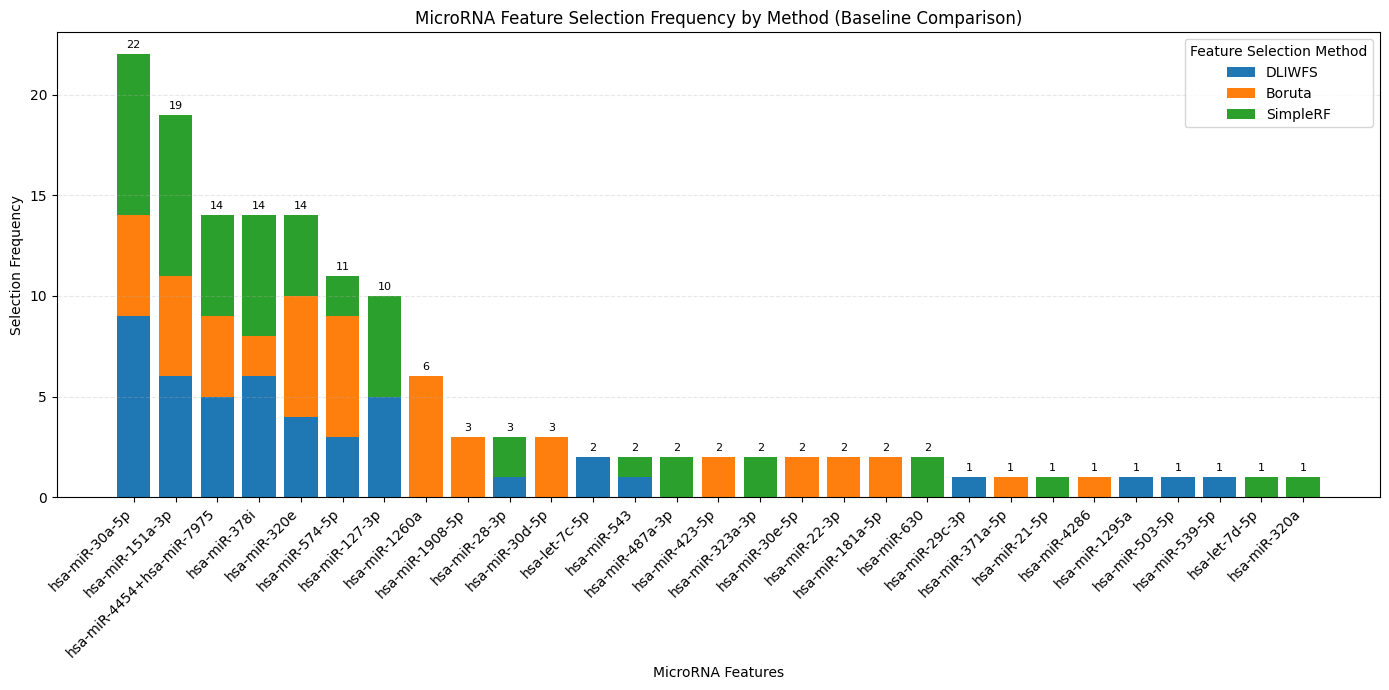

Feature Frequency by Method (sorted by total frequency):
-----------------------------------------------------
Feature		Total	DLIWFS	Boruta	SimpleRF
hsa-miR-30a-5p	22	9	5	8
hsa-miR-151a-3p	19	6	5	8
hsa-miR-4454+hsa-miR-7975	14	5	4	5
hsa-miR-378i	14	6	2	6
hsa-miR-320e	14	4	6	4
hsa-miR-574-5p	11	3	6	2
hsa-miR-127-3p	10	5	0	5
hsa-miR-1260a	6	0	6	0
hsa-miR-1908-5p	3	0	3	0
hsa-miR-28-3p	3	1	0	2
hsa-miR-30d-5p	3	0	3	0
hsa-let-7c-5p	2	2	0	0
hsa-miR-543	2	1	0	1
hsa-miR-487a-3p	2	0	0	2
hsa-miR-423-5p	2	0	2	0
hsa-miR-323a-3p	2	0	0	2
hsa-miR-30e-5p	2	0	2	0
hsa-miR-22-3p	2	0	2	0
hsa-miR-181a-5p	2	0	2	0
hsa-miR-630	2	0	0	2
hsa-miR-29c-3p	1	1	0	0
hsa-miR-371a-5p	1	0	1	0
hsa-miR-21-5p	1	0	0	1
hsa-miR-4286	1	0	1	0
hsa-miR-1295a	1	1	0	0
hsa-miR-503-5p	1	1	0	0
hsa-miR-539-5p	1	1	0	0
hsa-let-7d-5p	1	0	0	1
hsa-miR-320a	1	0	0	1


In [33]:
os.chdir('/home/jupy/miRNA/Acute_WL/Log2_MachineLearning_Results')

from collections import defaultdict
# Prepare data
methods = {
    'DLIWFS': dliwfs_default_results['selected_features'],
    'Boruta': boruta_default_results['selected_features'],
    'SimpleRF': simpleRF_default_results['selected_features']
}

# Get all unique features across all methods
all_features = set()
for method_features in methods.values():
    for arr in method_features:
        all_features.update(arr)
all_features = sorted(all_features)

# Create count matrix: rows=features, columns=methods
count_matrix = np.zeros((len(all_features), len(methods)))
for i, feature in enumerate(all_features):
    for j, (method_name, method_features) in enumerate(methods.items()):
        count = sum(feature in arr for arr in method_features)
        count_matrix[i, j] = count

# Sort features by total count (sum across methods)
total_counts = count_matrix.sum(axis=1)
sort_idx = np.argsort(-total_counts)  # Descending order
sorted_features = np.array(all_features)[sort_idx]
sorted_counts = count_matrix[sort_idx]

sorted_features_BL=sorted_features

# Get feature names
feature_names = np.array(feature_id_ls['OB_BL'])[sorted_features]

# Create stacked bar plot
plt.figure(figsize=(14, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Distinct colors for each method
bar_width = 0.8

# Plot stacked bars
bottom = np.zeros(len(sorted_features))
for j, method_name in enumerate(methods.keys()):
    plt.bar(range(len(sorted_features)), sorted_counts[:, j], 
            bottom=bottom, color=colors[j], 
            width=bar_width, label=method_name)
    bottom += sorted_counts[:, j]

# Customize plot
plt.title('MicroRNA Feature Selection Frequency by Method (Baseline Comparison)')
plt.xlabel('MicroRNA Features')
plt.ylabel('Selection Frequency')
plt.xticks(range(len(sorted_features)), feature_names, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Feature Selection Method')

# Add value labels for total counts
for i, total in enumerate(bottom):
    if total > 0:  # Only label bars with some counts
        plt.text(i, total + 0.2, f'{int(total)}', 
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('feature_selection_feature_frequency_comparison_BL.pdf', 
            format='pdf', 
            bbox_inches='tight', 
            dpi=300)
plt.show()

# Print sorted frequency table
print("Feature Frequency by Method (sorted by total frequency):")
print("-----------------------------------------------------")
print("Feature\t\tTotal\tDLIWFS\tBoruta\tSimpleRF")
for i, feature in enumerate(sorted_features):
    counts = sorted_counts[i]
    if sum(counts) > 0:  # Only print features that were selected
        print(f"{feature_names[i]}\t{int(sum(counts))}\t{int(counts[0])}\t{int(counts[1])}\t{int(counts[2])}")

### Why limit our scope to 7 top features 
Here we take the final 7 as features within scope, because 1) suggested by other research usually 3-7 features shows strong differentiation power in microRNA classfication; 2) the top 7 features are selected by at least 2 algorithms

In [34]:
n_features_analysed_BL=7

# Set X and y (PWL)

In [35]:
X_PWLvsL=np.vstack([feature_array['OB_PWL'],feature_array['LEAN']])
y_PWLvsL=np.array([1]*feature_array['OB_PWL'].shape[0]+[0]*feature_array['LEAN'].shape[0])
print(X_PWLvsL.shape,y_PWLvsL.shape)

X=X_PWLvsL
y=y_PWLvsL

(24, 828) (24,)


 10%|████████▍                                                                           | 1/10 [00:22<03:18, 22.10s/it]


Fold 1 completed:
Selected features (indices): [298 293 331 440 825]
Top 5 features sorted by importance: [331 298 293 825 440]
Test metrics (averaged over 100 seeds):
accuracy    : 0.7833
precision   : 1.0000
recall      : 0.6750
f1          : 0.7833
specificity : 1.0000
sensitivity : 0.6750
auc         : 1.0000


 20%|████████████████▊                                                                   | 2/10 [00:38<02:31, 18.97s/it]


Fold 2 completed:
Selected features (indices): [293  73 151 331 385]
Top 5 features sorted by importance: [331  73 151 293 385]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000


 30%|█████████████████████████▏                                                          | 3/10 [01:01<02:25, 20.77s/it]


Fold 3 completed:
Selected features (indices): [698 385 153  73 298]
Top 5 features sorted by importance: [385 153  73 298 698]
Test metrics (averaged over 100 seeds):
accuracy    : 0.6667
precision   : 0.0000
recall      : 0.0000
f1          : 0.0000
specificity : 1.0000
sensitivity : 0.0000
auc         : 0.3875


 40%|█████████████████████████████████▌                                                  | 4/10 [01:24<02:08, 21.44s/it]


Fold 4 completed:
Selected features (indices): [646 385  73 153 447]
Top 5 features sorted by importance: [ 73 153 447 385 646]
Test metrics (averaged over 100 seeds):
accuracy    : 0.4500
precision   : 0.0000
recall      : 0.0000
f1          : 0.0000
specificity : 0.6750
sensitivity : 0.0000
auc         : 0.0700


 50%|██████████████████████████████████████████                                          | 5/10 [01:45<01:47, 21.55s/it]


Fold 5 completed:
Selected features (indices): [ 73 385 151 331 698]
Top 5 features sorted by importance: [331 385 151  73 698]
Test metrics (averaged over 100 seeds):
accuracy    : 0.5000
precision   : 0.0000
recall      : 0.0000
f1          : 0.0000
specificity : 1.0000
sensitivity : 0.0000
auc         : 0.0000


 60%|██████████████████████████████████████████████████▍                                 | 6/10 [02:09<01:28, 22.12s/it]


Fold 6 completed:
Selected features (indices): [331 153 298 293  73]
Top 5 features sorted by importance: [153 331  73 293 298]
Test metrics (averaged over 100 seeds):
accuracy    : 0.9300
precision   : 0.9300
recall      : 1.0000
f1          : 0.9533
specificity : 0.8600
sensitivity : 1.0000
auc         : 1.0000


 70%|██████████████████████████████████████████████████████████▊                         | 7/10 [02:31<01:06, 22.06s/it]


Fold 7 completed:
Selected features (indices): [153 331 385 293  73]
Top 5 features sorted by importance: [ 73 331 293 385 153]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000


 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [02:52<00:43, 21.89s/it]


Fold 8 completed:
Selected features (indices): [298 385 293 331 698]
Top 5 features sorted by importance: [331 293 698 385 298]
Test metrics (averaged over 100 seeds):
accuracy    : 0.5000
precision   : 0.5000
recall      : 1.0000
f1          : 0.6667
specificity : 0.0000
sensitivity : 1.0000
auc         : 1.0000


 90%|███████████████████████████████████████████████████████████████████████████▌        | 9/10 [03:14<00:21, 21.75s/it]


Fold 9 completed:
Selected features (indices): [ 73 151 153 331 698]
Top 5 features sorted by importance: [331 698  73 151 153]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [03:35<00:00, 21.56s/it]



Fold 10 completed:
Selected features (indices): [153  73 293 298 331]
Top 5 features sorted by importance: [331  73 293 153 298]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000

=== Final Average Metrics ===
accuracy    : 0.7830
precision   : 0.6430
recall      : 0.6675
f1          : 0.6403
specificity : 0.8535
sensitivity : 0.6675
auc         : 0.7457


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]


Feature Removal Decisions:
Retained 73 - Removal would decrease accuracy from 0.9500 to 0.8600
Removed 293 - Improved accuracy from 0.9000 to 0.9500
Removed 399 - Improved accuracy from 0.9000 to 0.9500
Retained 153 - Removal would decrease accuracy from 0.9500 to 0.9500
Removed 415 - Improved accuracy from 0.9000 to 0.9500
Removed 332 - Improved accuracy from 0.9000 to 0.9500
Retained 153 - Removal would decrease accuracy from 0.9000 to 0.9000
Retained 276 - Removal would decrease accuracy from 0.9000 to 0.9000


 10%|████████▍                                                                           | 1/10 [00:18<02:50, 18.93s/it]


Fold 1 completed:
Selected features (indices): [ 73 331 153 385 276]
Top 5 features used: [ 73 331 153 385 276]
Test metrics (averaged over 100 seeds):
accuracy    : 0.6667
precision   : 1.0000
recall      : 0.5000
f1          : 0.6667
specificity : 1.0000
sensitivity : 0.5000
auc         : 0.5975

Feature Removal Decisions:
Retained 409 - Removal would decrease accuracy from 0.8100 to 0.8100
Retained 634 - Removal would decrease accuracy from 0.8500 to 0.8100
Retained 634 - Removal would decrease accuracy from 0.8500 to 0.8100


 20%|████████████████▊                                                                   | 2/10 [00:32<02:05, 15.75s/it]


Fold 2 completed:
Selected features (indices): [ 73 293 409 634 385]
Top 5 features used: [ 73 293 409 634 385]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000

Feature Removal Decisions:
Retained 385 - Removal would decrease accuracy from 0.8000 to 0.8000
Retained 73 - Removal would decrease accuracy from 0.8000 to 0.8000
Retained 284 - Removal would decrease accuracy from 0.8500 to 0.8000


 30%|█████████████████████████▏                                                          | 3/10 [00:45<01:42, 14.65s/it]


Fold 3 completed:
Selected features (indices): [331 293 385  73 284]
Top 5 features used: [331 293 385  73 284]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000

Feature Removal Decisions:
Retained 73 - Removal would decrease accuracy from 0.8100 to 0.8100
Retained 385 - Removal would decrease accuracy from 0.8100 to 0.8100
Retained 385 - Removal would decrease accuracy from 0.8500 to 0.8500
Retained 332 - Removal would decrease accuracy from 0.8500 to 0.8500


 40%|█████████████████████████████████▌                                                  | 4/10 [00:59<01:25, 14.32s/it]


Fold 4 completed:
Selected features (indices): [293  73 385 331 332]
Top 5 features used: [293  73 385 331 332]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000

Feature Removal Decisions:
Removed 293 - Improved accuracy from 0.8600 to 0.8700
Removed 409 - Improved accuracy from 0.8100 to 0.8700
Retained 153 - Removal would decrease accuracy from 0.8700 to 0.8700
Retained 331 - Removal would decrease accuracy from 0.9100 to 0.8700
Retained 153 - Removal would decrease accuracy from 0.9000 to 0.9000
Removed 385 - Improved accuracy from 0.9000 to 0.9500
Removed 397 - Improved accuracy from 0.9100 to 0.9500
Removed 167 - Improved accuracy from 0.8600 to 0.9500
Retained 501 - Removal would decrease accuracy from 0.9500 to 0.9500


 50%|██████████████████████████████████████████                                          | 5/10 [01:19<01:21, 16.39s/it]


Fold 5 completed:
Selected features (indices): [ 73 153 331 698 501]
Top 5 features used: [ 73 153 331 698 501]
Test metrics (averaged over 100 seeds):
accuracy    : 0.8350
precision   : 0.6700
recall      : 0.6700
f1          : 0.6700
specificity : 1.0000
sensitivity : 0.6700
auc         : 1.0000

Feature Removal Decisions:
Retained 73 - Removal would decrease accuracy from 0.8600 to 0.6800
Removed 293 - Improved accuracy from 0.8500 to 0.8600
Removed 385 - Improved accuracy from 0.8500 to 0.8600
Retained 586 - Removal would decrease accuracy from 0.9000 to 0.8600
Retained 586 - Removal would decrease accuracy from 0.9000 to 0.8100
Removed 37 - Improved accuracy from 0.8600 to 0.9000
Removed 586 - Improved accuracy from 0.8500 to 0.9000
Retained 409 - Removal would decrease accuracy from 0.9000 to 0.9000


 60%|██████████████████████████████████████████████████▍                                 | 6/10 [01:38<01:08, 17.21s/it]


Fold 6 completed:
Selected features (indices): [ 73 331 332 409  61]
Top 5 features used: [ 73 331 332 409  61]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000

Feature Removal Decisions:
Retained 331 - Removal would decrease accuracy from 0.8200 to 0.7600
Retained 73 - Removal would decrease accuracy from 0.8500 to 0.8200
Removed 385 - Improved accuracy from 0.8100 to 0.8500
Removed 473 - Improved accuracy from 0.8100 to 0.8500
Removed 597 - Improved accuracy from 0.8100 to 0.8500
Removed 23 - Improved accuracy from 0.8100 to 0.8500
Retained 61 - Removal would decrease accuracy from 0.8600 to 0.8500
Retained 61 - Removal would decrease accuracy from 0.8600 to 0.8100


 70%|██████████████████████████████████████████████████████████▊                         | 7/10 [01:57<00:53, 17.74s/it]


Fold 7 completed:
Selected features (indices): [293 331  73  61 698]
Top 5 features used: [293 331  73  61 698]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000

Feature Removal Decisions:
Removed 385 - Improved accuracy from 0.8600 to 0.9100
Removed 293 - Improved accuracy from 0.8600 to 0.9100
Retained 647 - Removal would decrease accuracy from 0.9600 to 0.9100
Retained 647 - Removal would decrease accuracy from 0.9100 to 0.9100
Retained 807 - Removal would decrease accuracy from 0.9600 to 0.9100


 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [02:13<00:34, 17.14s/it]


Fold 8 completed:
Selected features (indices): [331  73 647 153 807]
Top 5 features used: [331  73 647 153 807]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000

Feature Removal Decisions:
Removed 293 - Improved accuracy from 0.9100 to 0.9600
Removed 73 - Improved accuracy from 0.9100 to 0.9600
Removed 153 - Improved accuracy from 0.9100 to 0.9600
Retained 409 - Removal would decrease accuracy from 0.9600 to 0.9600
Removed 409 - Improved accuracy from 0.9100 to 0.9600
Removed 23 - Improved accuracy from 0.8600 to 0.9600
Retained 698 - Removal would decrease accuracy from 0.9600 to 0.9600
Retained 698 - Removal would decrease accuracy from 0.9600 to 0.9600


 90%|███████████████████████████████████████████████████████████████████████████▌        | 9/10 [02:32<00:17, 17.90s/it]


Fold 9 completed:
Selected features (indices): [331 385 488 698 647]
Top 5 features used: [331 385 488 698 647]
Test metrics (averaged over 100 seeds):
accuracy    : 0.5000
precision   : 0.0000
recall      : 0.0000
f1          : 0.0000
specificity : 1.0000
sensitivity : 0.0000
auc         : 0.0000

Feature Removal Decisions:
Removed 293 - Improved accuracy from 0.8500 to 0.9000
Removed 385 - Improved accuracy from 0.8500 to 0.9000
Removed 447 - Improved accuracy from 0.8500 to 0.9000
Retained 415 - Removal would decrease accuracy from 0.9000 to 0.9000
Removed 60 - Improved accuracy from 0.8500 to 0.9000
Removed 108 - Improved accuracy from 0.7600 to 0.9000
Removed 501 - Improved accuracy from 0.8500 to 0.9000
Retained 415 - Removal would decrease accuracy from 0.8500 to 0.8500
Retained 415 - Removal would decrease accuracy from 0.8000 to 0.8000


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [02:53<00:00, 17.35s/it]



Fold 10 completed:
Selected features (indices): [331  73 415 153 590]
Top 5 features used: [331  73 415 153 590]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000

=== Final Average Metrics ===
accuracy    : 0.9002
precision   : 0.8670
recall      : 0.8170
f1          : 0.8337
specificity : 1.0000
sensitivity : 0.8170
auc         : 0.8598


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_13466/2143557610.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10, 6))
 10%|████████▍                                                                           | 1/10 [00:09<01:21,  9.02s/it]


Fold 1 completed:
Selected features (indices): [ 73 331 293 399 153]
Top 5 features sorted by importance: [331 293  73 153 399]
Test metrics (averaged over 100 seeds):
accuracy    : 0.6667
precision   : 1.0000
recall      : 0.5000
f1          : 0.6667
specificity : 1.0000
sensitivity : 0.5000
auc         : 0.5400


 20%|████████████████▊                                                                   | 2/10 [00:18<01:12,  9.04s/it]


Fold 2 completed:
Selected features (indices): [ 73 293 409 634 385]
Top 5 features sorted by importance: [385 293  73 409 634]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000


 30%|█████████████████████████▏                                                          | 3/10 [00:27<01:03,  9.02s/it]


Fold 3 completed:
Selected features (indices): [331 293 385  73 284]
Top 5 features sorted by importance: [293 331  73 385 284]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000


 40%|█████████████████████████████████▌                                                  | 4/10 [00:36<00:54,  9.01s/it]


Fold 4 completed:
Selected features (indices): [293  73 385 331 332]
Top 5 features sorted by importance: [293 331 385  73 332]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000


 50%|██████████████████████████████████████████                                          | 5/10 [00:45<00:44,  8.99s/it]


Fold 5 completed:
Selected features (indices): [ 73 293 409 153 331]
Top 5 features sorted by importance: [ 73 331 293 153 409]
Test metrics (averaged over 100 seeds):
accuracy    : 0.5350
precision   : 0.0700
recall      : 0.0700
f1          : 0.0700
specificity : 1.0000
sensitivity : 0.0700
auc         : 1.0000


 60%|██████████████████████████████████████████████████▍                                 | 6/10 [00:54<00:36,  9.00s/it]


Fold 6 completed:
Selected features (indices): [ 73 331 293 385 586]
Top 5 features sorted by importance: [293 331  73 385 586]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000


 70%|██████████████████████████████████████████████████████████▊                         | 7/10 [01:03<00:26,  9.00s/it]


Fold 7 completed:
Selected features (indices): [293 331  73 385 473]
Top 5 features sorted by importance: [331 293 385  73 473]
Test metrics (averaged over 100 seeds):
accuracy    : 0.9500
precision   : 0.9500
recall      : 1.0000
f1          : 0.9667
specificity : 0.9000
sensitivity : 1.0000
auc         : 1.0000


 80%|███████████████████████████████████████████████████████████████████▏                | 8/10 [01:11<00:17,  8.98s/it]


Fold 8 completed:
Selected features (indices): [331  73 385 293 647]
Top 5 features sorted by importance: [331 293 385  73 647]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000


 90%|███████████████████████████████████████████████████████████████████████████▌        | 9/10 [01:20<00:08,  8.98s/it]


Fold 9 completed:
Selected features (indices): [331 385 293  73 153]
Top 5 features sorted by importance: [331 385 293  73 153]
Test metrics (averaged over 100 seeds):
accuracy    : 0.5000
precision   : 0.0000
recall      : 0.0000
f1          : 0.0000
specificity : 1.0000
sensitivity : 0.0000
auc         : 1.0000


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  9.00s/it]


Fold 10 completed:
Selected features (indices): [331  73 293 385 447]
Top 5 features sorted by importance: [331 293  73 447 385]
Test metrics (averaged over 100 seeds):
accuracy    : 1.0000
precision   : 1.0000
recall      : 1.0000
f1          : 1.0000
specificity : 1.0000
sensitivity : 1.0000
auc         : 1.0000

=== Final Average Metrics ===
accuracy    : 0.8652
precision   : 0.8020
recall      : 0.7570
f1          : 0.7703
specificity : 0.9900
sensitivity : 0.7570
auc         : 0.9540
Results saved to boruta_default_results_PWL.txt
Results saved to dliwfs_default_results_PWL.txt
Results saved to simpleRF_default_results_PWL.txt


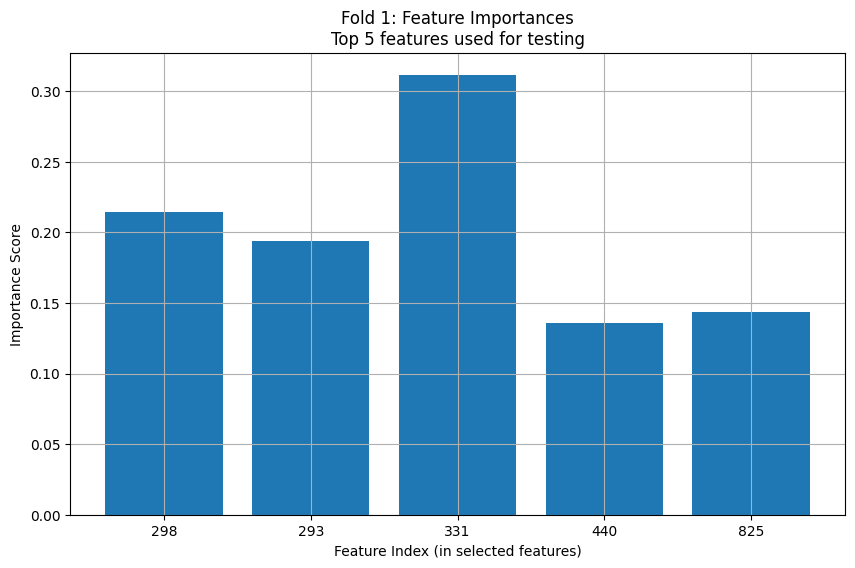

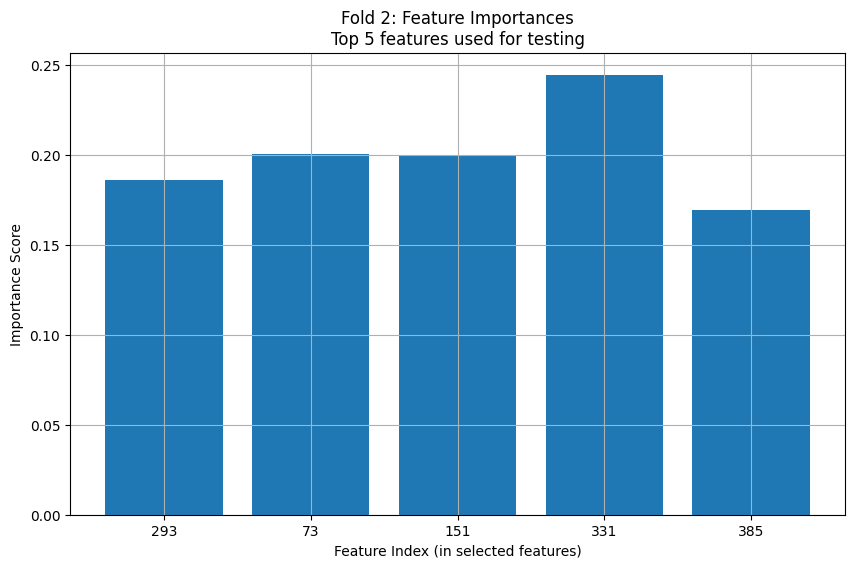

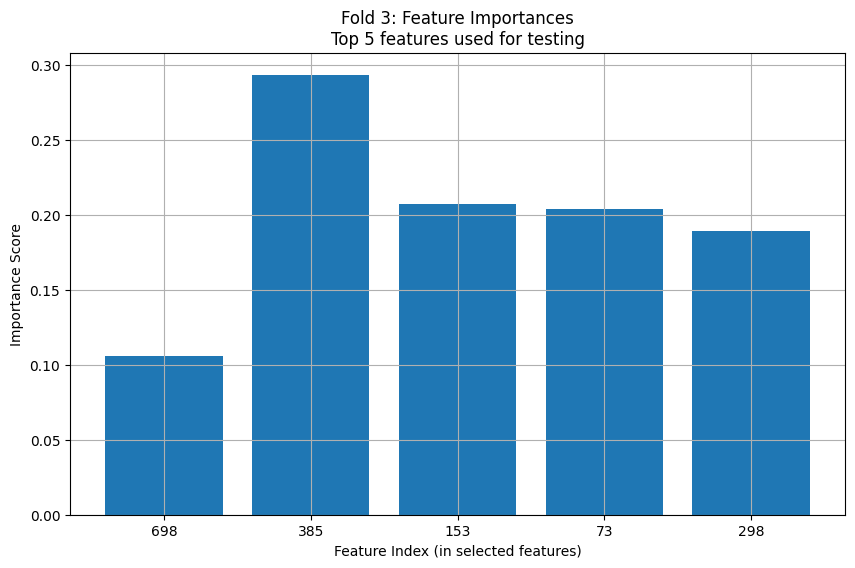

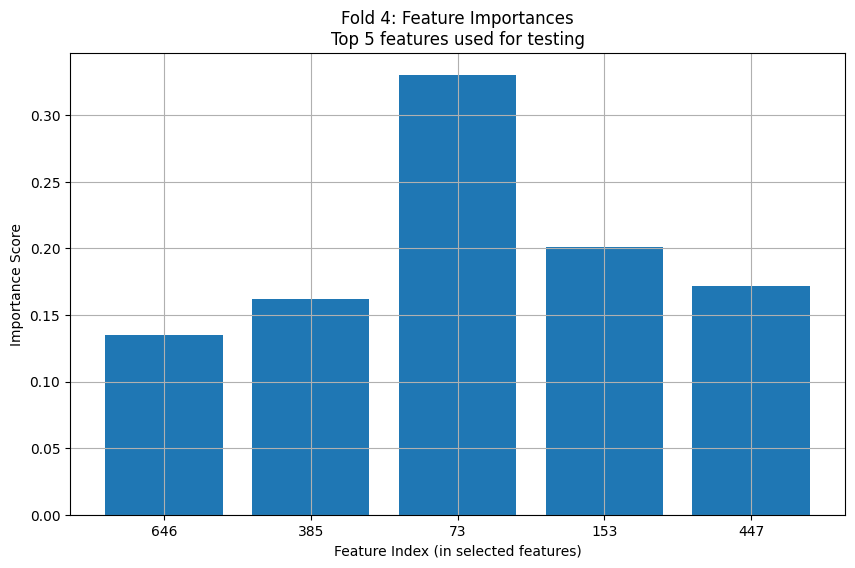

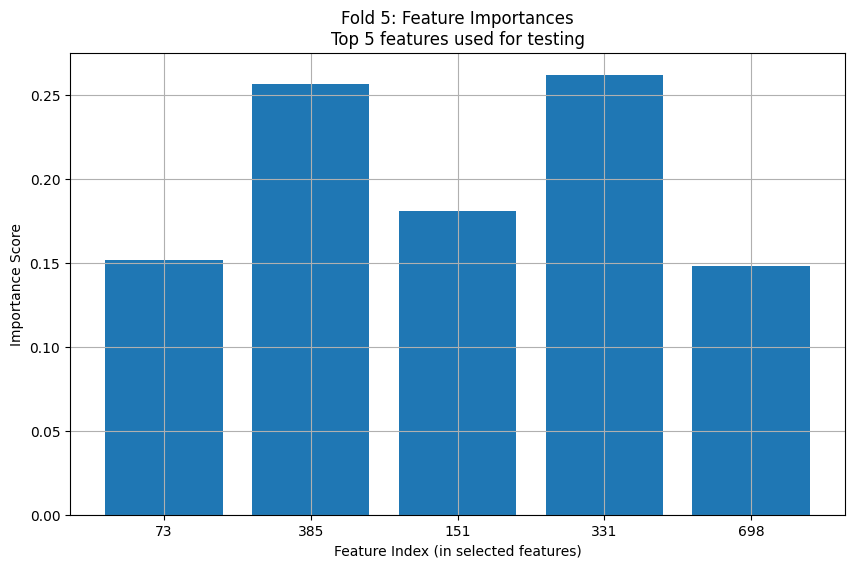

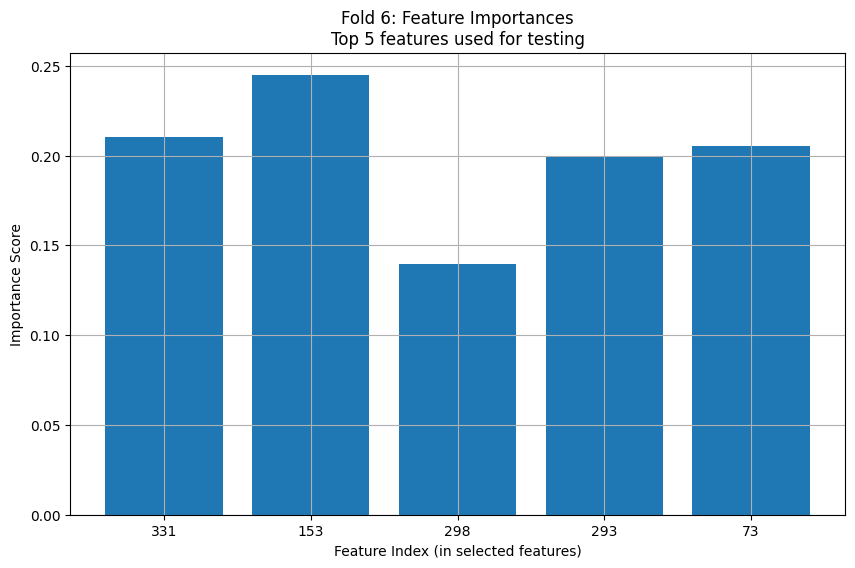

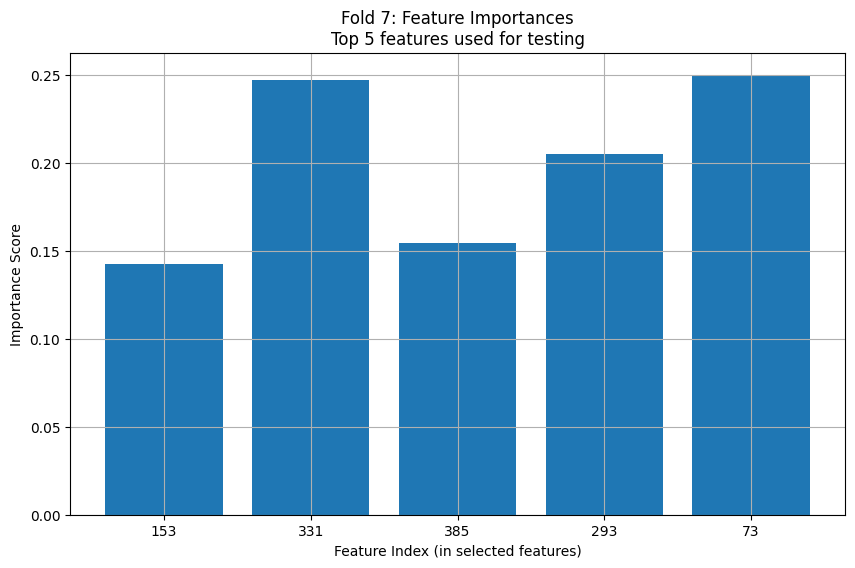

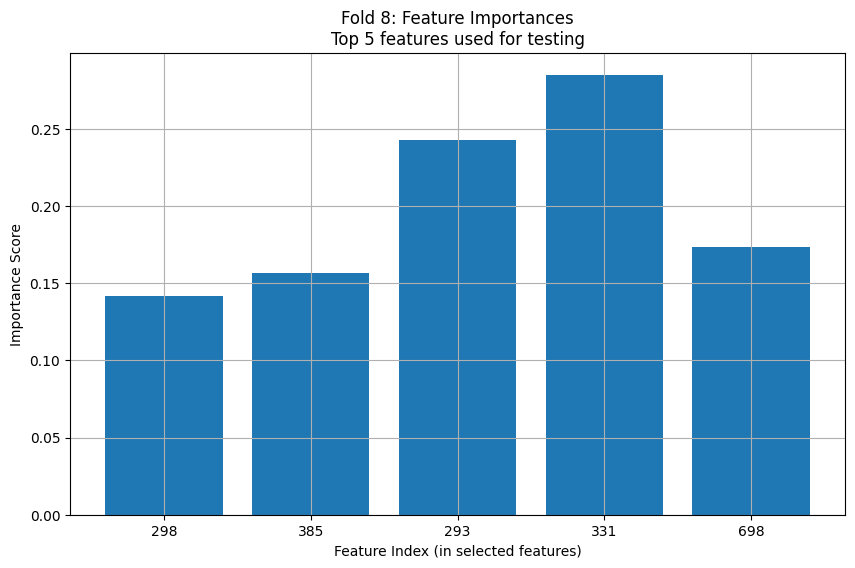

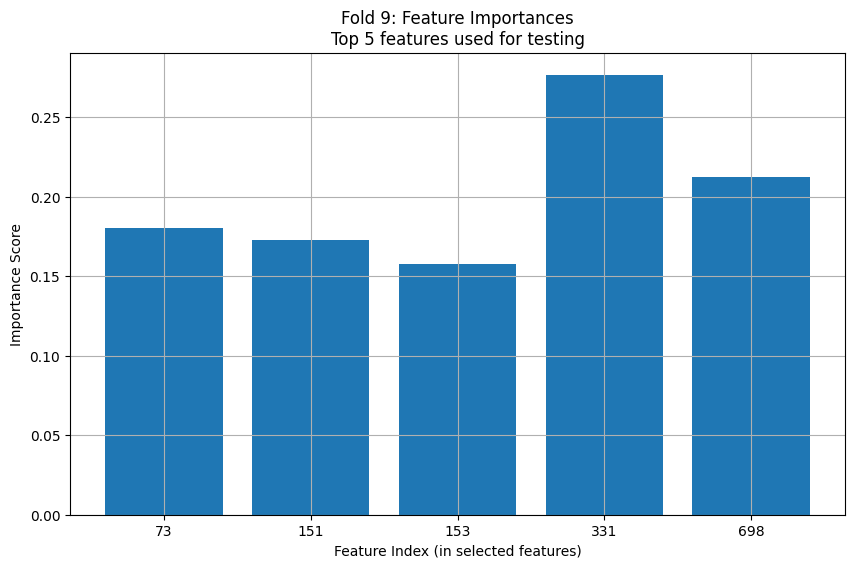

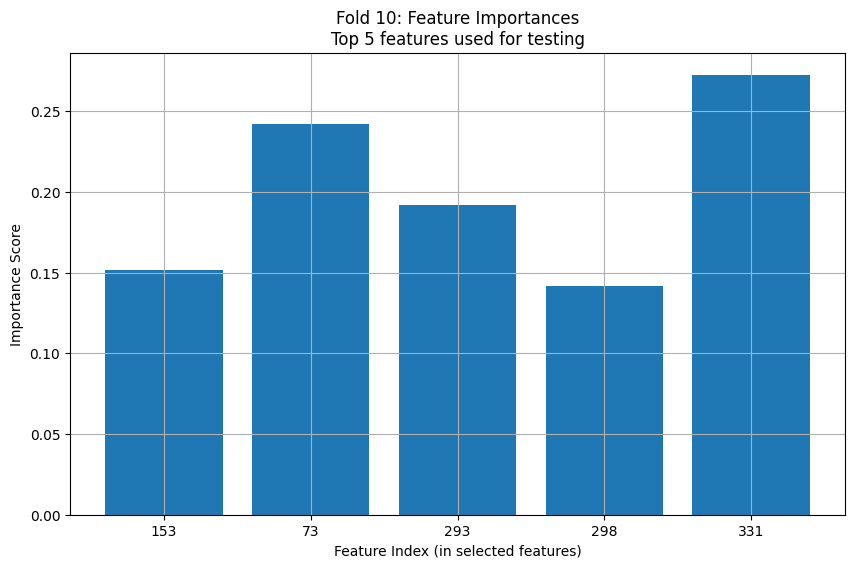

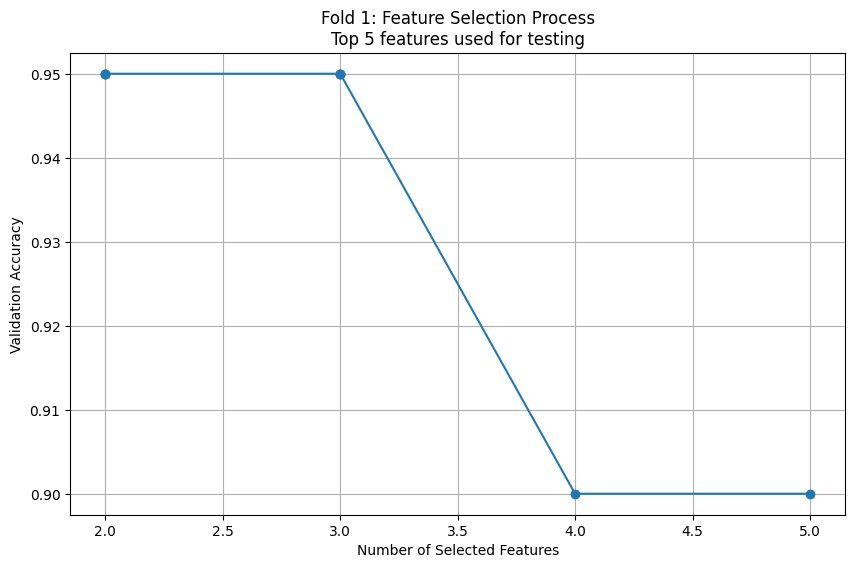

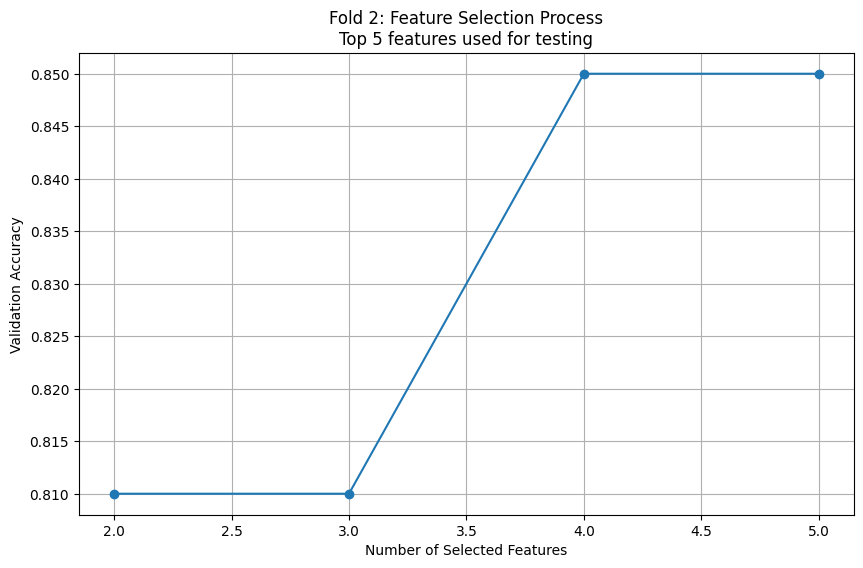

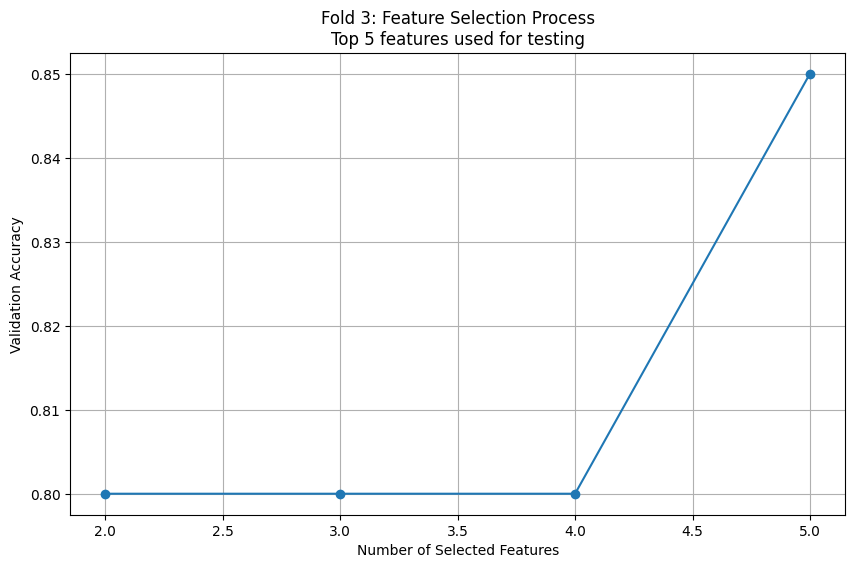

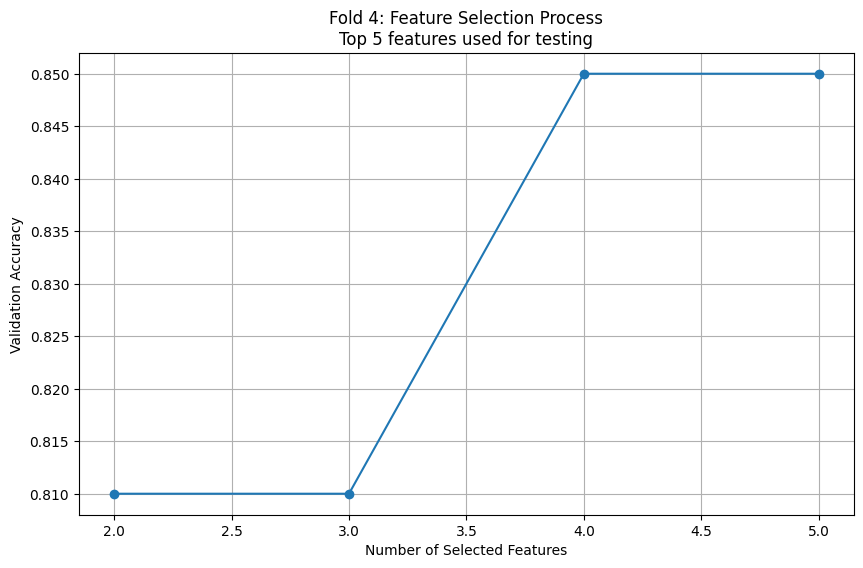

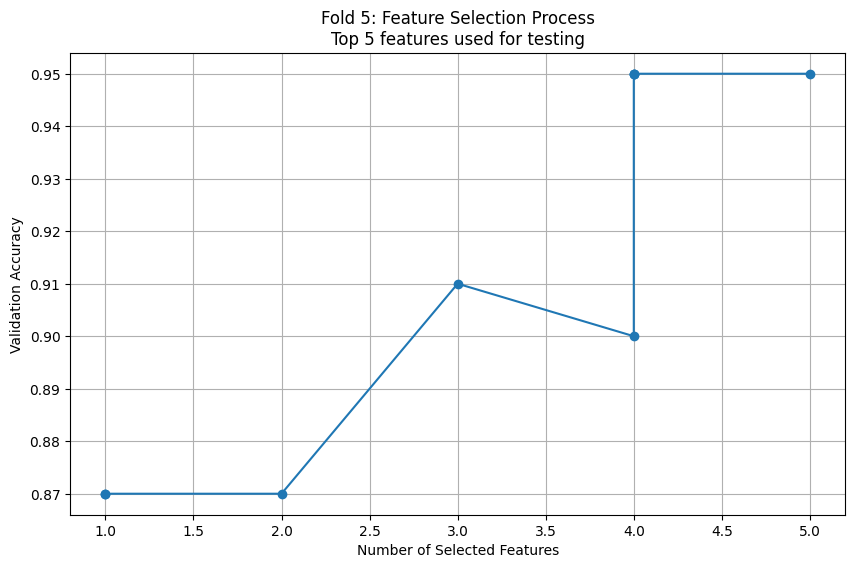

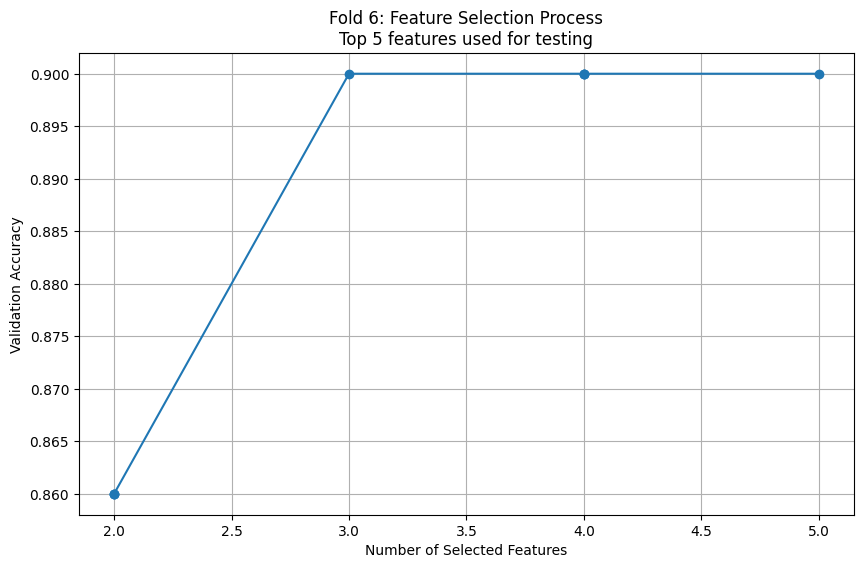

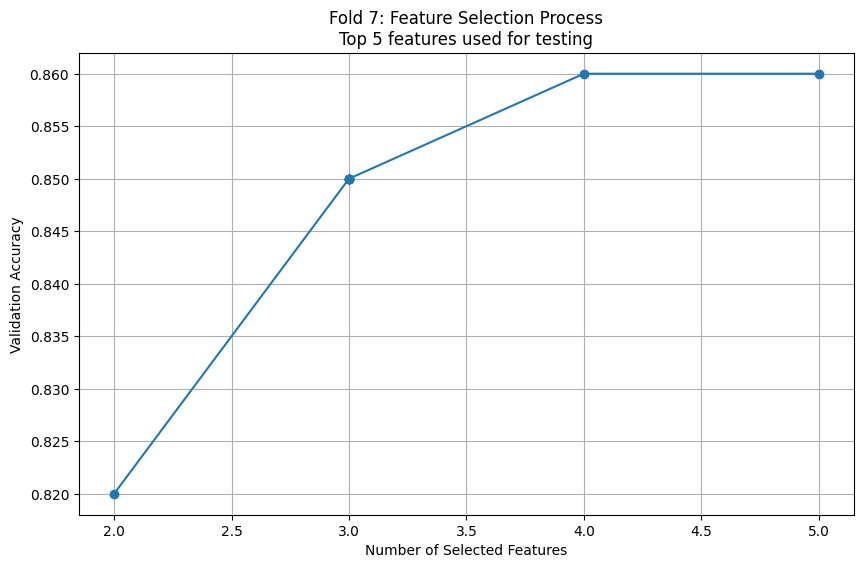

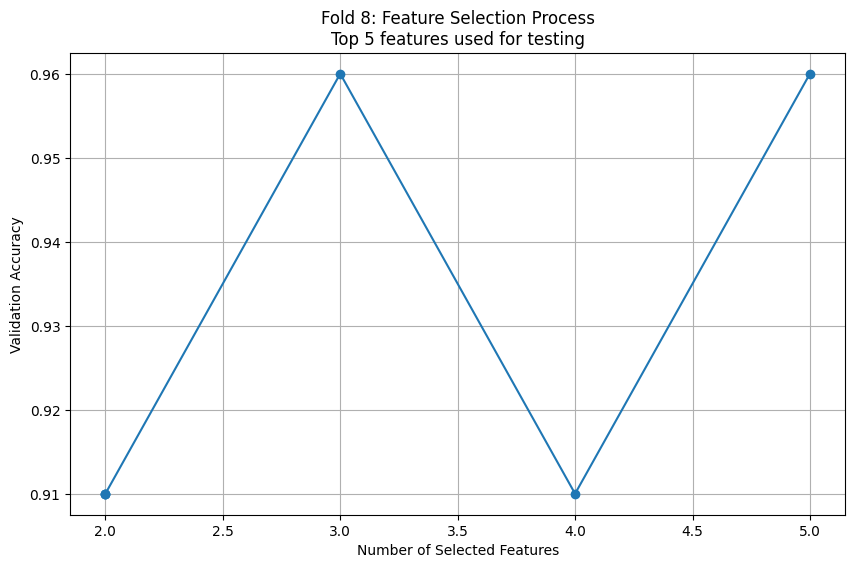

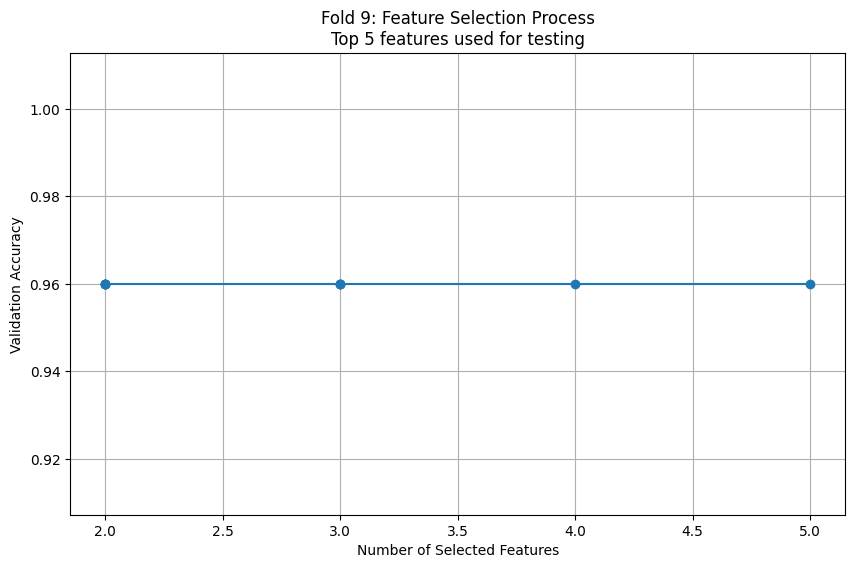

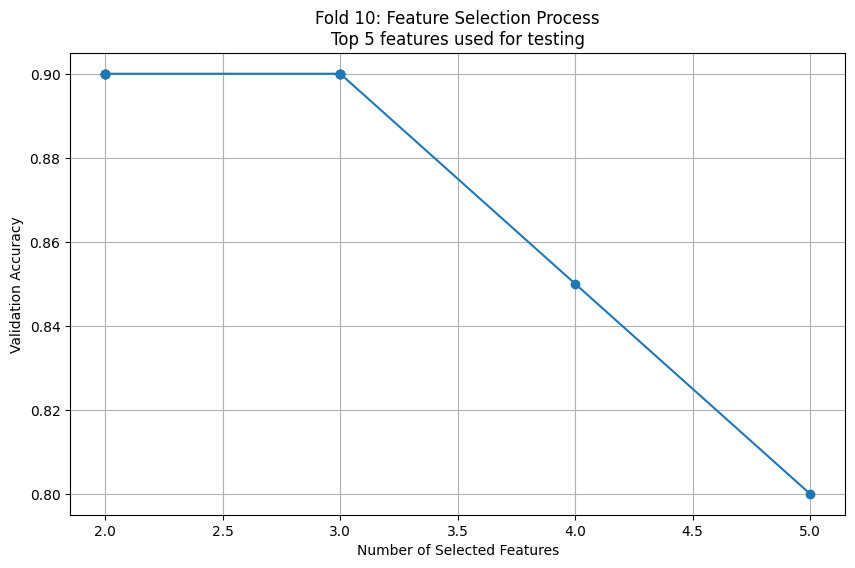

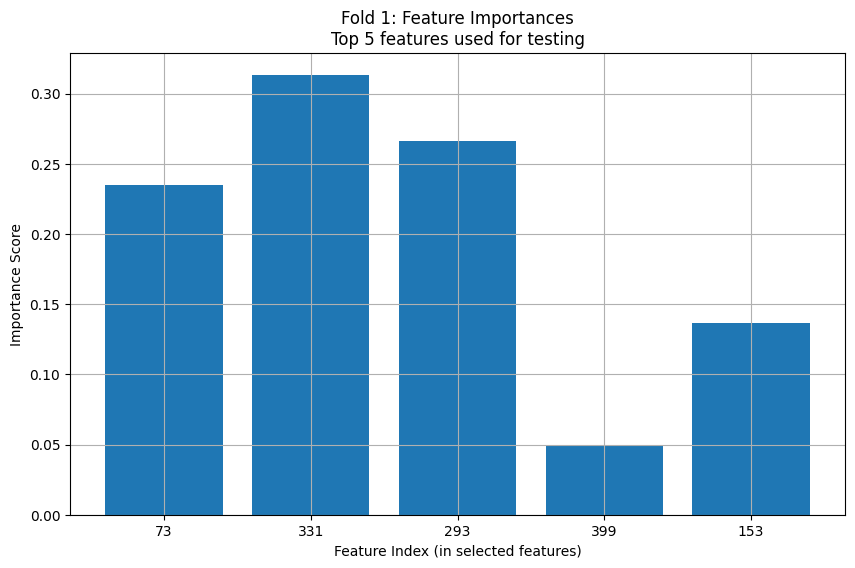

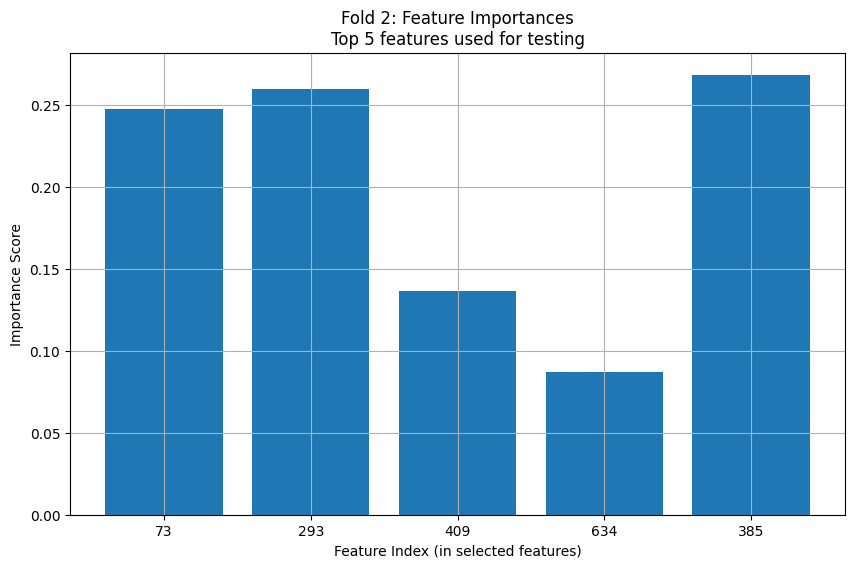

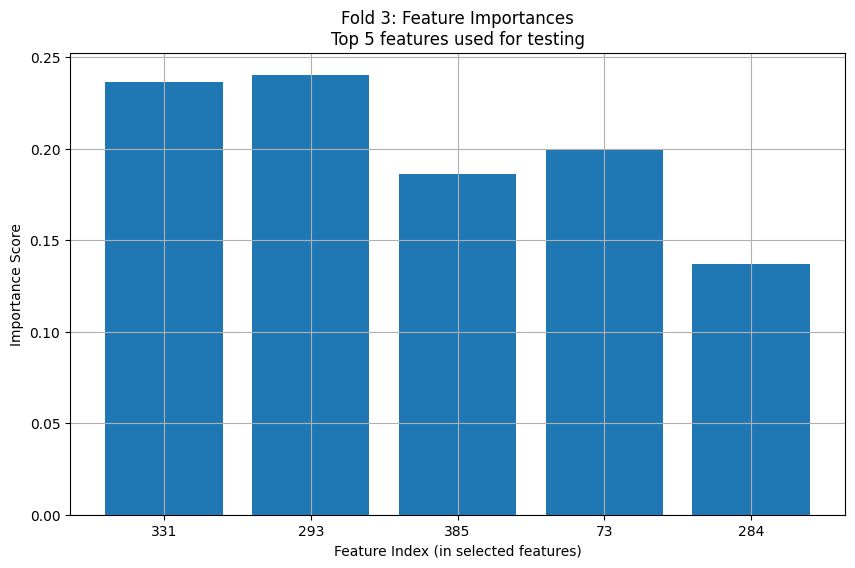

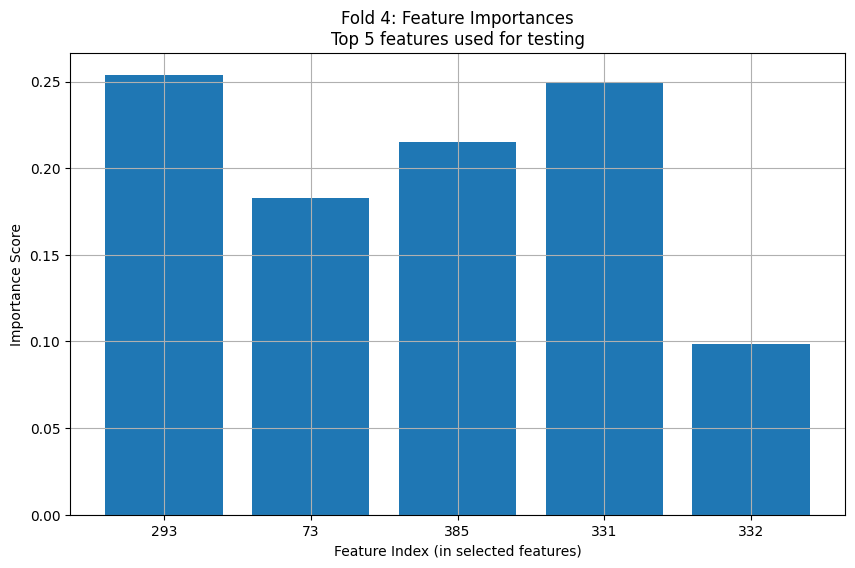

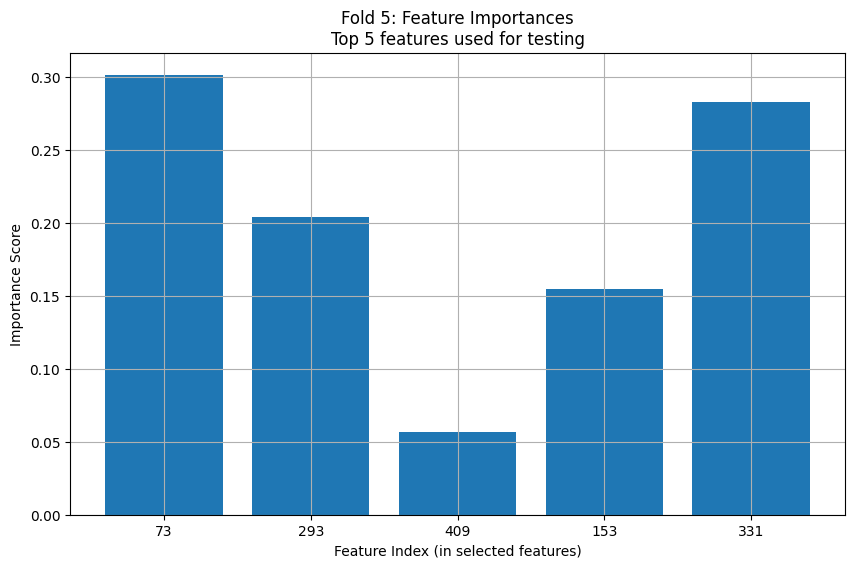

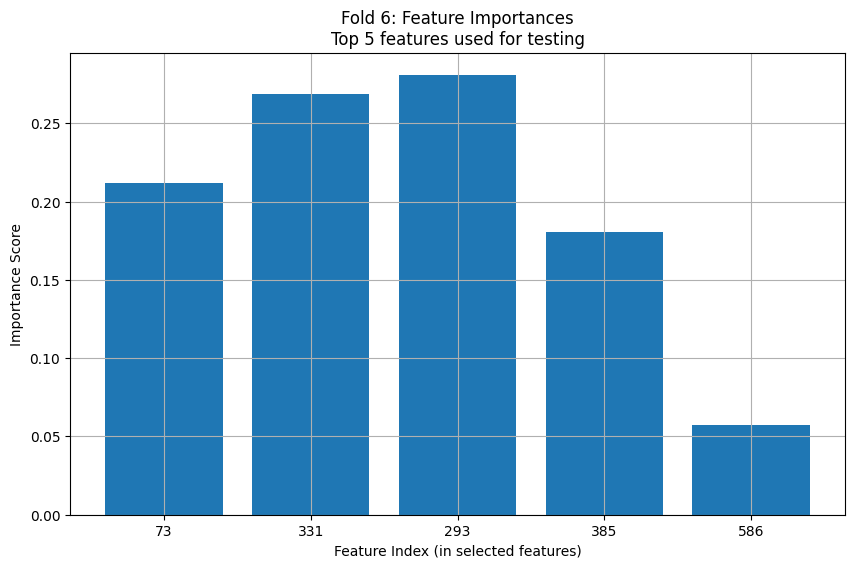

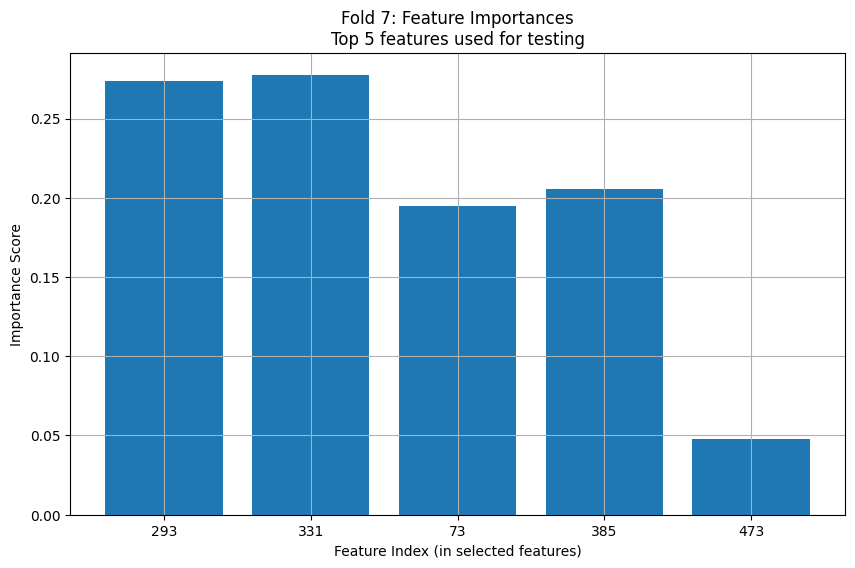

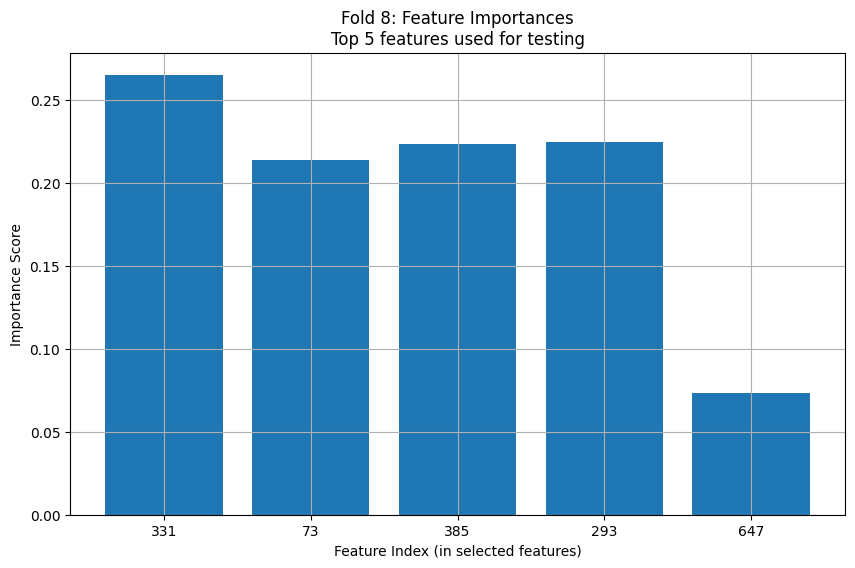

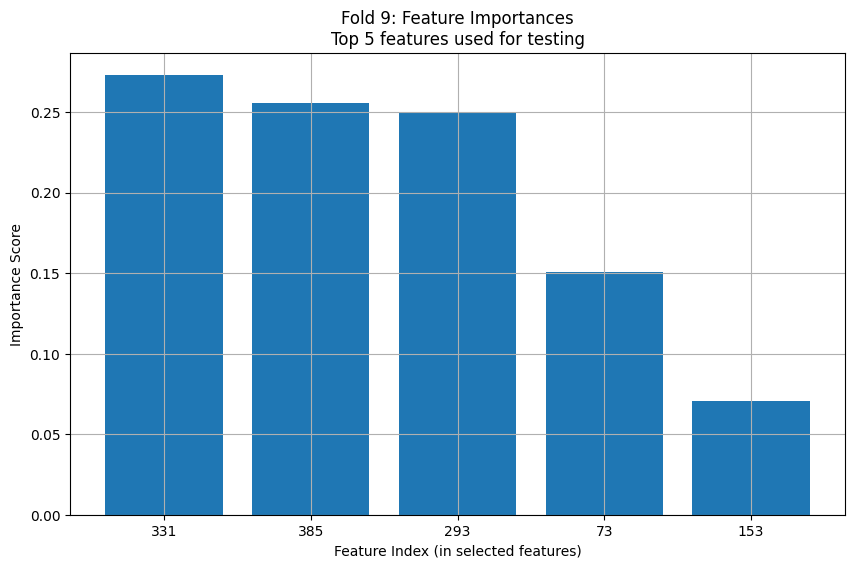

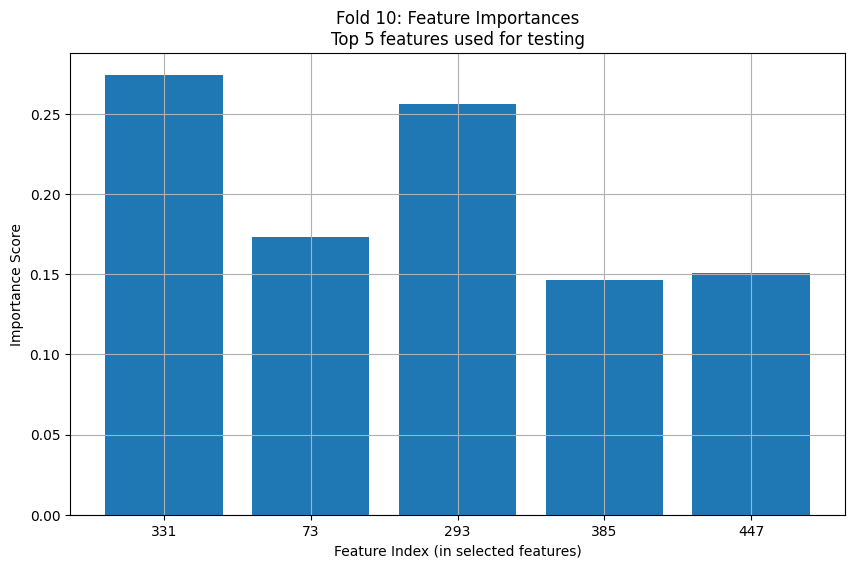

In [36]:
os.chdir('/home/jupy/miRNA/Acute_WL/Log2_MachineLearning_Results')

# ====================== Example Usage BuROTA======================
if __name__ == "__main__":    
    boruta_default_results_PWL = run_experiment_with_boruta(X, y, top_k=5, n_seeds=100, random_state=0)
    
# ====================== Example Usage DLI-WFS ======================
if __name__ == "__main__":  
    dliwfs_default_results_PWL = run_experiment_with_dliwfs(X, y, D=5, M=30, top_k=5, n_seeds=100, random_state=42)
        
# ====================== Simple RF ======================
if __name__ == "__main__":
    simpleRF_default_results_PWL = run_experiment_with_rf_feature_selection(X, y, top_k=5, n_seeds=100, random_state=42)

save_results_to_txt(boruta_default_results_PWL, "boruta_default_results_PWL.txt")
save_results_to_txt(dliwfs_default_results_PWL, "dliwfs_default_results_PWL.txt")
save_results_to_txt(simpleRF_default_results_PWL, "simpleRF_default_results_PWL.txt")

save_results_to_json(boruta_default_results_PWL, "boruta_default_results_PWL.json")
save_results_to_json(dliwfs_default_results_PWL, "dliwfs_default_results_PWL.json")
save_results_to_json(simpleRF_default_results_PWL, "simpleRF_default_results_PWL.json")

Load Results

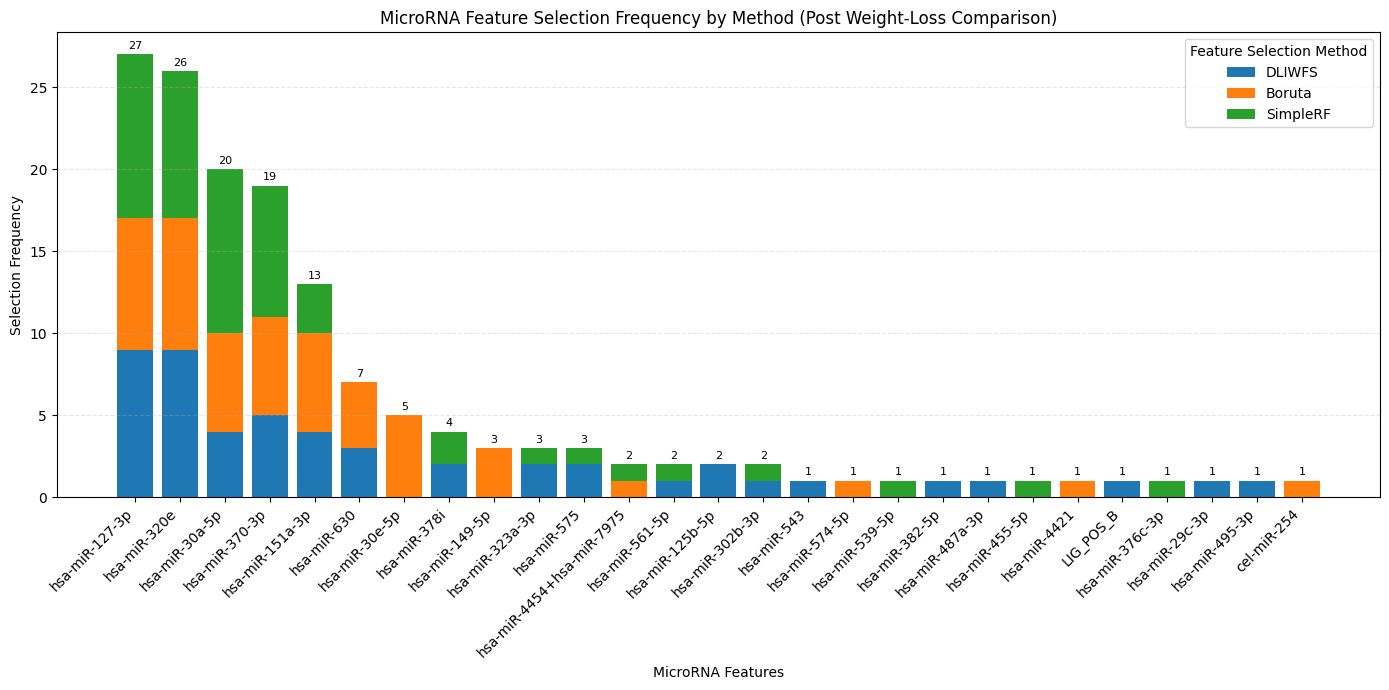

Feature Frequency by Method (sorted by total frequency):
-----------------------------------------------------
Feature		Total	DLIWFS	Boruta	SimpleRF
hsa-miR-127-3p	27	9	8	10
hsa-miR-320e	26	9	8	9
hsa-miR-30a-5p	20	4	6	10
hsa-miR-370-3p	19	5	6	8
hsa-miR-151a-3p	13	4	6	3
hsa-miR-630	7	3	4	0
hsa-miR-30e-5p	5	0	5	0
hsa-miR-378i	4	2	0	2
hsa-miR-149-5p	3	0	3	0
hsa-miR-323a-3p	3	2	0	1
hsa-miR-575	3	2	0	1
hsa-miR-4454+hsa-miR-7975	2	0	1	1
hsa-miR-561-5p	2	1	0	1
hsa-miR-125b-5p	2	2	0	0
hsa-miR-302b-3p	2	1	0	1
hsa-miR-543	1	1	0	0
hsa-miR-574-5p	1	0	1	0
hsa-miR-539-5p	1	0	0	1
hsa-miR-382-5p	1	1	0	0
hsa-miR-487a-3p	1	1	0	0
hsa-miR-455-5p	1	0	0	1
hsa-miR-4421	1	0	1	0
LIG_POS_B	1	1	0	0
hsa-miR-376c-3p	1	0	0	1
hsa-miR-29c-3p	1	1	0	0
hsa-miR-495-3p	1	1	0	0
cel-miR-254	1	0	1	0


In [37]:
os.chdir('/home/jupy/miRNA/Acute_WL/Log2_MachineLearning_Results')

methods = {
    'DLIWFS': dliwfs_default_results_PWL['selected_features'],
    'Boruta': boruta_default_results_PWL['selected_features'],
    'SimpleRF': simpleRF_default_results_PWL['selected_features']
}

# Get all unique features across all methods
all_features = set()
for method_features in methods.values():
    for arr in method_features:
        all_features.update(arr)
all_features = sorted(all_features)

# Create count matrix: rows=features, columns=methods
count_matrix = np.zeros((len(all_features), len(methods)))
for i, feature in enumerate(all_features):
    for j, (method_name, method_features) in enumerate(methods.items()):
        count = sum(feature in arr for arr in method_features)
        count_matrix[i, j] = count

# Sort features by total count (sum across methods)
total_counts = count_matrix.sum(axis=1)
sort_idx = np.argsort(-total_counts)  # Descending order
sorted_features = np.array(all_features)[sort_idx]
sorted_counts = count_matrix[sort_idx]

sorted_features_PWL=sorted_features

# Get feature names
feature_names = np.array(feature_id_ls['OB_BL'])[sorted_features]

# Create stacked bar plot
plt.figure(figsize=(14, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Distinct colors for each method
bar_width = 0.8

# Plot stacked bars
bottom = np.zeros(len(sorted_features))
for j, method_name in enumerate(methods.keys()):
    plt.bar(range(len(sorted_features)), sorted_counts[:, j], 
            bottom=bottom, color=colors[j], 
            width=bar_width, label=method_name)
    bottom += sorted_counts[:, j]

# Customize plot
plt.title('MicroRNA Feature Selection Frequency by Method (Post Weight-Loss Comparison)')
plt.xlabel('MicroRNA Features')
plt.ylabel('Selection Frequency')
plt.xticks(range(len(sorted_features)), feature_names, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Feature Selection Method')

# Add value labels for total counts
for i, total in enumerate(bottom):
    if total > 0:  # Only label bars with some counts
        plt.text(i, total + 0.2, f'{int(total)}', 
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('feature_selection_feature_frequency_comparison_PWL.pdf', 
            format='pdf', 
            bbox_inches='tight', 
            dpi=300)
plt.show()

# Print sorted frequency table
print("Feature Frequency by Method (sorted by total frequency):")
print("-----------------------------------------------------")
print("Feature\t\tTotal\tDLIWFS\tBoruta\tSimpleRF")
for i, feature in enumerate(sorted_features):
    counts = sorted_counts[i]
    if sum(counts) > 0:  # Only print features that were selected
        print(f"{feature_names[i]}\t{int(sum(counts))}\t{int(counts[0])}\t{int(counts[1])}\t{int(counts[2])}")

#### limit our scope to 6 features here 
Use the similar jutisfication, we limit our scope of features to analyse to 6. Becuase 6 is between 3-8. And the top 6 features are selected by at least two agorithms

In [38]:
n_features_analysed_PWL=6

# Obese Baseline vs Post Weigt-Loss Comparison

In [32]:
X_OB_PWLvsX_OB_BL=np.vstack([feature_array['OB_PWL'],feature_array['OB_BL']])
y_OB_PWLvsy_OB_BL=np.array([1]*feature_array['OB_PWL'].shape[0]+[0]*feature_array['OB_BL'].shape[0])

X=X_OB_PWLvsX_OB_BL
y=y_OB_PWLvsy_OB_BL

The classification performance is at chance level. This makes sense as our small sample size is not enough for the ML to capture complex/intricate differnce betweeen pre and post weight-loss within the obese cohort. 

# Observe Overlapping

In [39]:
BL_features_to_analyse=sorted_features_BL[0:n_features_analysed_BL]
PWL_features_to_analyse=sorted_features_PWL[0:n_features_analysed_PWL]

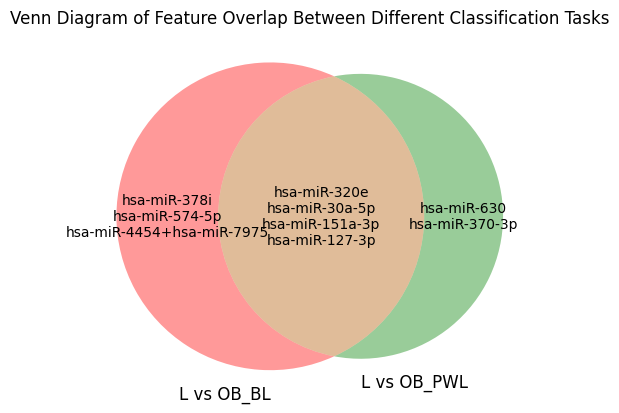

In [40]:
# Extract sets
set_bl = set(np.array(feature_id_ls['OB_BL'])[BL_features_to_analyse])
set_pwl = set(np.array(feature_id_ls['OB_BL'])[PWL_features_to_analyse])

# Create Venn diagram
venn = venn2([set_bl, set_pwl], set_labels=('L vs OB_BL', 'L vs OB_PWL'))

# Customize labels to show actual elements
venn.get_label_by_id('10').set_text('\n'.join(set_bl - set_pwl))      # Only in BL
venn.get_label_by_id('01').set_text('\n'.join(set_pwl - set_bl))      # Only in PWL
venn.get_label_by_id('11').set_text('\n'.join(set_bl & set_pwl))      # In both

# Display plot
plt.title("Venn Diagram of Feature Overlap Between Different Classification Tasks")
#plt.savefig('venn_feature_overlap.pdf')
plt.show()

Use tsne to visualisation high dimensional feature space:
<br> Hypothesis 1: Features responde to WL (only in BL) should make Lean and PWL closer and BL far from these two
<br> Hypothesis 2: Features persist to WL (both BL and PWL) should make BL and PWL closer and Lean far from these two

In [41]:
WL_respond_features=list(set(BL_features_to_analyse)-set(PWL_features_to_analyse))#list(set_bl - set_pwl)
WL_persist_features=list(set(BL_features_to_analyse)&set(PWL_features_to_analyse))#list(set_bl & set_pwl)
WL_remodel_features=list(set(PWL_features_to_analyse)-set(BL_features_to_analyse))

WL_respond_feature_names = np.array(feature_id_ls['OB_BL'])[WL_respond_features]
WL_persist_feature_names = np.array(feature_id_ls['OB_BL'])[WL_persist_features]
WL_remodel_feature_names=np.array(feature_id_ls['OB_BL'])[WL_remodel_features]

# Create DataFrames
df_WL_respond_features= pd.DataFrame({
    'feature_id': WL_respond_features,
    'feature_name': WL_respond_feature_names })
df_WL_persist_features = pd.DataFrame({
    'feature_id': WL_persist_features,
    'feature_name': WL_persist_feature_names})
df_WL_remodel_features = pd.DataFrame({
    'feature_id': WL_remodel_features,
    'feature_name': WL_remodel_feature_names})

#### Try to classify using only WL-persistent features 

In [42]:
def random_forest_cv_performance(X, y, n_estimators=100, random_state=None):
    """
    Evaluate Random Forest classifier performance using 10-fold stratified cross-validation.
    
    Parameters:
    - X: Feature matrix (n_samples, n_features)
    - y: Target vector (n_samples,)
    - n_estimators: Number of trees in the forest
    - random_state: Random state for reproducibility
    
    Returns:
    Dictionary containing lists of performance metrics across all folds:
    'accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'auc'
    """
    # Initialize the Random Forest classifier
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    
    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    
    # Initialize metrics storage
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'specificity': [],
        'sensitivity': [],
        'auc': []
    }
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train the model
        rf.fit(X_train, y_train)
        
        # Predictions
        y_pred = rf.predict(X_test)
        y_prob = rf.predict_proba(X_test)[:, 1]  # probabilities for positive class
        
        # Calculate metrics
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred, zero_division=0))
        metrics['recall'].append(recall_score(y_test, y_pred, zero_division=0))
        metrics['f1'].append(f1_score(y_test, y_pred, zero_division=0))
        
        # Calculate specificity and sensitivity from confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # same as recall
        
        metrics['specificity'].append(specificity)
        metrics['sensitivity'].append(sensitivity)
        
        # Calculate AUC
        try:
            auc = roc_auc_score(y_test, y_prob)
        except ValueError:
            # Handle case when only one class is present
            auc = 0.5
        metrics['auc'].append(auc)
    
    return metrics

def print_performance_metrics(performance_metrics):
    
    # Calculate mean of each metric
    mean_metrics = {
        'accuracy': np.mean(performance_metrics['accuracy']),
        'precision': np.mean(performance_metrics['precision']),
        'recall': np.mean(performance_metrics['recall']),
        'f1': np.mean(performance_metrics['f1']),
        'specificity': np.mean(performance_metrics['specificity']),
        'sensitivity': np.mean(performance_metrics['sensitivity']),
        'auc': np.mean(performance_metrics['auc'])
    }

    # Print the average performance metrics
    print("\nAverage Performance Metrics Across Folds:")
    print("----------------------------------------")
    print(f"Accuracy:    {mean_metrics['accuracy']:.4f}")
    print(f"Precision:   {mean_metrics['precision']:.4f}")
    print(f"Recall:      {mean_metrics['recall']:.4f}")
    print(f"F1 Score:    {mean_metrics['f1']:.4f}")
    print(f"Specificity: {mean_metrics['specificity']:.4f}")
    print(f"Sensitivity: {mean_metrics['sensitivity']:.4f}")
    print(f"AUC:         {mean_metrics['auc']:.4f}")
    print("----------------------------------------")

    # Calculate and print standard deviations
    std_metrics = {
        metric: np.std(values) 
        for metric, values in performance_metrics.items()
    }

    print("\nStandard Deviations Across Folds:")
    print("--------------------------------")
    for metric, std in std_metrics.items():
        print(f"{metric.capitalize():<12}: {std:.4f}")
    print("--------------------------------")


In [43]:
from datetime import datetime

def run_multiple_seeds(X, y, n_estimators=100, num_seeds=100, output_file="rf_multiseed_results.txt"):
    """
    Run random forest CV performance with multiple seeds and save results.
    
    Parameters:
    - X: Feature matrix
    - y: Target vector
    - n_estimators: Number of trees in random forest
    - num_seeds: Number of different random seeds to try
    - output_file: Name of the output text file
    """
    # Initialize storage for all results
    all_results = {
        'seed': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'specificity': [],
        'sensitivity': [],
        'auc': []
    }
    
    # Create header for output file
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    header = f"Random Forest Performance Across {num_seeds} Seeds\n"
    header += f"Generated on: {timestamp}\n"
    header += "Seed\tAccuracy\tPrecision\tRecall\tF1\tSpecificity\tSensitivity\tAUC\n"
    
    # Open file and write header
    with open(output_file, 'w') as f:
        f.write(header)
    
    # Run for each seed
    for seed in range(num_seeds):
        # Run CV with current seed
        metrics = random_forest_cv_performance(X, y, n_estimators=n_estimators, random_state=seed)
        
        # Calculate mean for each metric
        mean_metrics = {
            'accuracy': np.mean(metrics['accuracy']),
            'precision': np.mean(metrics['precision']),
            'recall': np.mean(metrics['recall']),
            'f1': np.mean(metrics['f1']),
            'specificity': np.mean(metrics['specificity']),
            'sensitivity': np.mean(metrics['sensitivity']),
            'auc': np.mean(metrics['auc'])
        }
        
        # Store results
        all_results['seed'].append(seed)
        for metric in mean_metrics:
            all_results[metric].append(mean_metrics[metric])
        
        # Write to file
        with open(output_file, 'a') as f:
            f.write(f"{seed}\t{mean_metrics['accuracy']:.4f}\t{mean_metrics['precision']:.4f}\t"
                    f"{mean_metrics['recall']:.4f}\t{mean_metrics['f1']:.4f}\t"
                    f"{mean_metrics['specificity']:.4f}\t{mean_metrics['sensitivity']:.4f}\t"
                    f"{mean_metrics['auc']:.4f}\n")
    
    # Calculate final averages across all seeds
    final_avg = {
        'accuracy': np.mean(all_results['accuracy']),
        'precision': np.mean(all_results['precision']),
        'recall': np.mean(all_results['recall']),
        'f1': np.mean(all_results['f1']),
        'specificity': np.mean(all_results['specificity']),
        'sensitivity': np.mean(all_results['sensitivity']),
        'auc': np.mean(all_results['auc'])
    }
    
    # Calculate standard deviations
    final_std = {
        'accuracy': np.std(all_results['accuracy']),
        'precision': np.std(all_results['precision']),
        'recall': np.std(all_results['recall']),
        'f1': np.std(all_results['f1']),
        'specificity': np.std(all_results['specificity']),
        'sensitivity': np.std(all_results['sensitivity']),
        'auc': np.std(all_results['auc'])
    }
    
    # Append final averages to file
    with open(output_file, 'a') as f:
        f.write("\nFinal Average Performance Across All Seeds:\n")
        f.write("----------------------------------------\n")
        f.write(f"Accuracy:    {final_avg['accuracy']:.4f} ± {final_std['accuracy']:.4f}\n")
        f.write(f"Precision:   {final_avg['precision']:.4f} ± {final_std['precision']:.4f}\n")
        f.write(f"Recall:      {final_avg['recall']:.4f} ± {final_std['recall']:.4f}\n")
        f.write(f"F1 Score:    {final_avg['f1']:.4f} ± {final_std['f1']:.4f}\n")
        f.write(f"Specificity: {final_avg['specificity']:.4f} ± {final_std['specificity']:.4f}\n")
        f.write(f"Sensitivity: {final_avg['sensitivity']:.4f} ± {final_std['sensitivity']:.4f}\n")
        f.write(f"AUC:         {final_avg['auc']:.4f} ± {final_std['auc']:.4f}\n")
        f.write("----------------------------------------\n")
    
    # Print final results to console
    print("\nFinal Average Performance Across All Seeds:")
    print("----------------------------------------")
    print(f"Accuracy:    {final_avg['accuracy']:.4f} ± {final_std['accuracy']:.4f}")
    print(f"Precision:   {final_avg['precision']:.4f} ± {final_std['precision']:.4f}")
    print(f"Recall:      {final_avg['recall']:.4f} ± {final_std['recall']:.4f}")
    print(f"F1 Score:    {final_avg['f1']:.4f} ± {final_std['f1']:.4f}")
    print(f"Specificity: {final_avg['specificity']:.4f} ± {final_std['specificity']:.4f}")
    print(f"Sensitivity: {final_avg['sensitivity']:.4f} ± {final_std['sensitivity']:.4f}")
    print(f"AUC:         {final_avg['auc']:.4f} ± {final_std['auc']:.4f}")
    print("----------------------------------------")
    print(f"\nDetailed results saved to: {output_file}")
    
    return final_avg, final_std


In [44]:
os.chdir('/home/jupy/miRNA/Acute_WL/Log2_MachineLearning_Results')

#### BL Performances

##### BL using all BL features

In [45]:
final_avg, final_std = run_multiple_seeds(X_BLvsL[:, BL_features_to_analyse], y_BLvsL)


Final Average Performance Across All Seeds:
----------------------------------------
Accuracy:    0.8652 ± 0.0345
Precision:   0.8033 ± 0.0742
Recall:      0.8110 ± 0.0643
F1 Score:    0.7965 ± 0.0655
Specificity: 0.9165 ± 0.0255
Sensitivity: 0.8110 ± 0.0643
AUC:         0.9700 ± 0.0436
----------------------------------------

Detailed results saved to: rf_multiseed_results.txt


##### BL using all persisent features

In [46]:
final_avg, final_std = run_multiple_seeds(X_BLvsL[:, WL_persist_features], 
                                          y_BLvsL,output_file="BL_WL-persistF_rf_100seed_results.txt")


Final Average Performance Across All Seeds:
----------------------------------------
Accuracy:    0.8108 ± 0.0344
Precision:   0.7292 ± 0.0728
Recall:      0.7470 ± 0.0423
F1 Score:    0.7232 ± 0.0528
Specificity: 0.8755 ± 0.0606
Sensitivity: 0.7470 ± 0.0423
AUC:         0.9550 ± 0.0558
----------------------------------------

Detailed results saved to: BL_WL-persistF_rf_100seed_results.txt


#### PWL Performances

##### PWL using all PWL features

In [47]:
final_avg, final_std = run_multiple_seeds(X_PWLvsL[:,PWL_features_to_analyse], y_PWLvsL
                                          ,output_file="PWL_allF_rf_100seed_results.txt")


Final Average Performance Across All Seeds:
----------------------------------------
Accuracy:    0.8660 ± 0.0207
Precision:   0.7740 ± 0.0601
Recall:      0.7475 ± 0.0342
F1 Score:    0.7534 ± 0.0419
Specificity: 0.9840 ± 0.0338
Sensitivity: 0.7475 ± 0.0342
AUC:         0.9048 ± 0.0511
----------------------------------------

Detailed results saved to: PWL_allF_rf_100seed_results.txt


##### PWL using all persisent features

In [48]:
final_avg, final_std = run_multiple_seeds(X_PWLvsL[:,WL_persist_features], y_PWLvsL
                                          ,output_file="PWL_WL-persistF_rf_100seed_results.txt")


Final Average Performance Across All Seeds:
----------------------------------------
Accuracy:    0.8378 ± 0.0216
Precision:   0.7475 ± 0.0542
Recall:      0.7475 ± 0.0342
F1 Score:    0.7367 ± 0.0387
Specificity: 0.9280 ± 0.0408
Sensitivity: 0.7475 ± 0.0342
AUC:         0.9153 ± 0.0552
----------------------------------------

Detailed results saved to: PWL_WL-persistF_rf_100seed_results.txt


# Feature Correlation

In [49]:
PWL_features_to_analyse=PWL_features_to_analyse.tolist()
BL_features_to_analyse=BL_features_to_analyse.tolist()
PWL_features_to_analyse_names=(np.array(feature_id_ls['OB_PWL'])[PWL_features_to_analyse]).tolist()
BL_features_to_analyse_names=(np.array(feature_id_ls['OB_BL'])[BL_features_to_analyse]).tolist()

/tmp/ipykernel_13466/840683432.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 0.9, 1])  # Adjusted for bottom colorbar


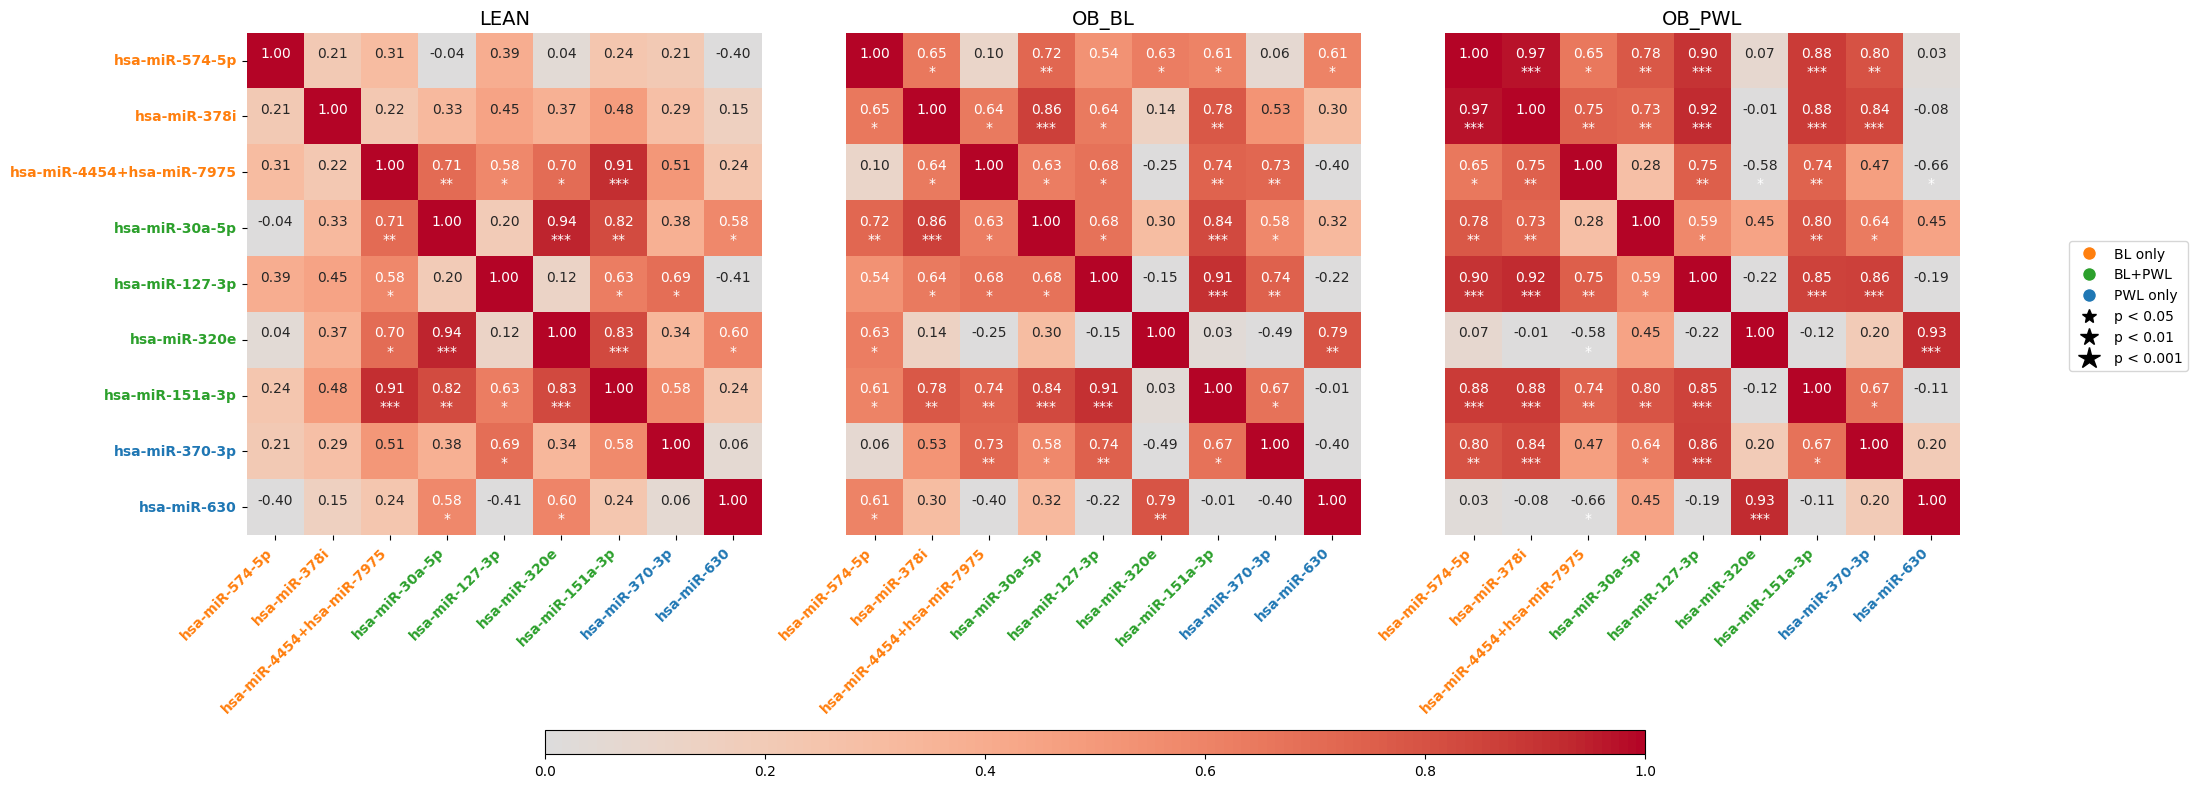

In [50]:
from scipy.stats import pearsonr

# First, create dictionaries to map features to their names
bl_feature_dict = dict(zip(BL_features_to_analyse, BL_features_to_analyse_names))
pwl_feature_dict = dict(zip(PWL_features_to_analyse, PWL_features_to_analyse_names))

# Get all unique features
all_features = set(bl_feature_dict.keys()).union(set(pwl_feature_dict.keys()))

# Categorize features
wl_responding = []    # BL only (orange)
wl_persistent = []    # Both BL and PWL (green)
weight_remodelling = []  # PWL only (blue)

for feat in all_features:
    in_bl = feat in bl_feature_dict
    in_pwl = feat in pwl_feature_dict
    
    if in_bl and in_pwl:
        wl_persistent.append((feat, bl_feature_dict[feat]))  # Using BL name
    elif in_bl:
        wl_responding.append((feat, bl_feature_dict[feat]))
    else:
        weight_remodelling.append((feat, pwl_feature_dict[feat]))

# Combine and sort features by category
sorted_features = wl_responding + wl_persistent + weight_remodelling
features_for_corr = [x[0] for x in sorted_features]
features_for_corr_names = [x[1] for x in sorted_features]

# Create color mapping for x-axis labels
label_colors = []
for feat, name in sorted_features:
    if feat in bl_feature_dict and feat in pwl_feature_dict:
        label_colors.append('#2CA02C')  # Green - WL-Persistent
    elif feat in bl_feature_dict:
        label_colors.append('#FF7F0E')  # Orange - WL-responding
    else:
        label_colors.append('#1F77B4')  # Blue - Weight Remodelling

# Rest of your code remains the same...
# Create individual DataFrames with sorted features
lean_df = pd.DataFrame(feature_array['LEAN'][:, features_for_corr], columns=features_for_corr_names)
ob_bl_df = pd.DataFrame(feature_array['OB_BL'][:, features_for_corr], columns=features_for_corr_names)
ob_pwl_df = pd.DataFrame(feature_array['OB_PWL'][:, features_for_corr], columns=features_for_corr_names)

# Convert to numeric and clean data
lean_df = lean_df.apply(pd.to_numeric, errors='coerce').dropna()
ob_bl_df = ob_bl_df.apply(pd.to_numeric, errors='coerce').dropna()
ob_pwl_df = ob_pwl_df.apply(pd.to_numeric, errors='coerce').dropna()

# Calculate correlation matrices AND p-values
def calculate_corr_with_pvals(df):
    corr_matrix = df.corr()
    pval_matrix = np.zeros_like(corr_matrix)
    
    for i in range(len(features_for_corr_names)):
        for j in range(len(features_for_corr_names)):
            if i != j:
                r, p = pearsonr(df.iloc[:, i], df.iloc[:, j])
                pval_matrix[i, j] = p
            else:
                pval_matrix[i, j] = 1  # Diagonal
    
    return corr_matrix, pd.DataFrame(pval_matrix, index=corr_matrix.index, columns=corr_matrix.columns)

corr_lean, p_lean = calculate_corr_with_pvals(lean_df)
corr_ob_bl, p_ob_bl = calculate_corr_with_pvals(ob_bl_df)
corr_ob_pwl, p_ob_pwl = calculate_corr_with_pvals(ob_pwl_df)

# --- Plotting modifications ---
fig, axes = plt.subplots(1, 3, figsize=(22, 8), gridspec_kw={'width_ratios': [1, 1, 1]})

def plot_heatmap_with_significance(ax, corr, pvals, title, show_yticks=True):
    # Base heatmap
    sns.heatmap(corr, ax=ax, cmap='coolwarm', center=0, annot_kws={"va": 'bottom'},
                annot=True, fmt=".2f", vmin=0, vmax=1,
                xticklabels=features_for_corr_names,
                yticklabels=features_for_corr_names if show_yticks else False,
                cbar=False)
    
    # Add significance asterisks inside the grid cells
    for i in range(len(features_for_corr_names)):
        for j in range(len(features_for_corr_names)):
            if i != j:
                p = pvals.iloc[i, j]
                if p < 0.001:
                    ax.text(j+0.5, i+0.7, '***', ha='center', va='center', 
                           fontsize=10, color='white' if abs(corr.iloc[i,j]) > 0.5 else 'black')
                elif p < 0.01:
                    ax.text(j+0.5, i+0.7, '**', ha='center', va='center', 
                           fontsize=10, color='white' if abs(corr.iloc[i,j]) > 0.5 else 'black')
                elif p < 0.05:
                    ax.text(j+0.5, i+0.7, '*', ha='center', va='center', 
                           fontsize=10, color='white' if abs(corr.iloc[i,j]) > 0.5 else 'black')
    
    ax.set_title(title, fontsize=14)


# Plot all three heatmaps
plot_heatmap_with_significance(axes[0], corr_lean, p_lean, 'LEAN', show_yticks=True)
plot_heatmap_with_significance(axes[1], corr_ob_bl, p_ob_bl, 'OB_BL', show_yticks=False)
plot_heatmap_with_significance(axes[2], corr_ob_pwl, p_ob_pwl, 'OB_PWL', show_yticks=False)

# --- Add colorbar at the bottom ---
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])  # [left, bottom, width, height]
fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation='horizontal')

# --- Add legend on the right side ---
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='BL only',
               markerfacecolor='#FF7F0E', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='BL+PWL',
               markerfacecolor='#2CA02C', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='PWL only',
               markerfacecolor='#1F77B4', markersize=10),
    plt.Line2D([0], [0], marker='*', color='k', label='p < 0.05',
               markersize=10, linestyle='None'),
    plt.Line2D([0], [0], marker='*', color='k', label='p < 0.01',
               markersize=13, linestyle='None'),
    plt.Line2D([0], [0], marker='*', color='k', label='p < 0.001',
               markersize=16, linestyle='None')
]

fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1,0.7), fontsize=10)

# --- Color labels and formatting ---
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    for label, color in zip(ax.get_xticklabels(), label_colors):
        label.set_color(color)
        label.set_fontweight('bold')
    
    if ax == axes[0]:
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        for label, color in zip(ax.get_yticklabels(), label_colors):
            label.set_color(color)
            label.set_fontweight('bold')

plt.tight_layout(rect=[0, 0.08, 0.9, 1])  # Adjusted for bottom colorbar

plt.savefig('feature_correlations_sorted.pdf', bbox_inches='tight', dpi=300)

# UMAP

# Test Feature Significance

In [52]:
def calculate_comparisons(feature_array, WL_respond_or_persist_features, group1, group2, alpha=0.05):
    """
    Calculate statistical test results (parametric or non-parametric) for all specified features between two groups
    
    Args:
        feature_array: Dictionary of numpy arrays (each [samples × features])
        WL_respond_features: List of feature indices to analyze
        group1, group2: Group names to compare
        alpha: Significance level for normality and variance tests
        
    Returns: DataFrame with feature names, test type, p-values, effect sizes, adjusted p-values, and log fold changes
    """
    results = []
    
    for feature in WL_respond_or_persist_features:
        try:
            # Extract data for both groups - ensure they're numeric
            data1 = np.asarray(feature_array[group1][:, feature], dtype=float)
            data2 = np.asarray(feature_array[group2][:, feature], dtype=float)
            
            # Remove any potential NaN/inf values
            data1 = data1[np.isfinite(data1)]
            data2 = data2[np.isfinite(data2)]
            
            # Skip if either group has no valid data
            if len(data1) < 3 or len(data2) < 3:  # Need at least 3 samples for normality test
                continue
                
            # Calculate log fold change (base 2)
            mean1 = np.mean(data1)
            mean2 = np.mean(data2)
            # Add small pseudocount to avoid log(0)
            #log_fc = np.log2((mean1 + 1e-5) / (mean2 + 1e-5))
            log_fc=(mean1 + 1e-5) / (mean2 + 1e-5)
            
            # Check normality (Shapiro-Wilk test)
            _, p1 = shapiro(data1)
            _, p2 = shapiro(data2)
            
            # Check variance homogeneity (Levene's test)
            _, p_levene = levene(data1, data2)
            
            # Decide which test to use
            if p1 > alpha and p2 > alpha and p_levene > alpha:
                # Parametric (t-test)
                test_type = 't-test'
                stat, p = ttest_ind(data1, data2, equal_var=True)
                
                # Calculate Cohen's d effect size
                n1, n2 = len(data1), len(data2)
                pooled_std = np.sqrt(((n1-1)*np.std(data1, ddof=1)**2 + (n2-1)*np.std(data2, ddof=1)**2) / (n1 + n2 - 2))
                effect_size = (np.mean(data1) - np.mean(data2)) / pooled_std
            else:
                # Non-parametric (Mann-Whitney U)
                test_type = 'Mann-Whitney U'
                stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
                
                # Calculate rank-biserial correlation effect size
                n1, n2 = len(data1), len(data2)
                effect_size = 1 - (2 * stat) / (n1 * n2)
            
            results.append({
                'feature': feature,
                'test_type': test_type,
                'p_value': p,
                'effect_size': effect_size,
                'log2_fold_change': log_fc,
                'mean_group1': mean1,
                'mean_group2': mean2,
                'comparison': f"{group1}_vs_{group2}"
            })
            
        except Exception as e:
            print(f"Error processing feature {feature}: {str(e)}")
            continue
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Adjust p-values for multiple comparisons (skip NaN values)
    pvals = df['p_value'].values
    if len(pvals) > 0 and np.any(~np.isnan(pvals)):
        df['adjusted_p'] = multipletests(pvals, method='fdr_bh')[1]
    else:
        df['adjusted_p'] = np.nan
    
    return df

In [54]:
os.chdir('/home/jupy/miRNA/Acute_WL/Log2_MachineLearning_Results')

all_features=list(set(BL_features_to_analyse + PWL_features_to_analyse))
bl_vs_lean = calculate_comparisons(feature_array, all_features, 'OB_BL', 'LEAN')
pwl_vs_lean = calculate_comparisons(feature_array, all_features, 'OB_PWL', 'LEAN')

if not bl_vs_lean.empty and not pwl_vs_lean.empty:
    DE_sig_df = pd.merge(bl_vs_lean, pwl_vs_lean, on='feature', 
                         suffixes=('_BL_vs_Lean', '_PWL_vs_Lean'))
    
    # Calculate changes
    DE_sig_df['p_value_change'] = DE_sig_df['adjusted_p_PWL_vs_Lean'] - DE_sig_df['adjusted_p_BL_vs_Lean']
    DE_sig_df['effect_size_change'] = DE_sig_df['effect_size_PWL_vs_Lean'] - DE_sig_df['effect_size_BL_vs_Lean']
    DE_sig_df['abs_effect_size_change'] = abs(DE_sig_df['effect_size_change'])
    DE_sig_df['log2_fold_change_change'] = DE_sig_df['log2_fold_change_PWL_vs_Lean'] - DE_sig_df['log2_fold_change_BL_vs_Lean']
    DE_sig_df['abs_log2_fold_change_change'] = abs(DE_sig_df['log2_fold_change_change'])
    
    # Sort by largest changes (you can choose either effect size or fold change)
    DE_sig_df = DE_sig_df.sort_values(
        by='abs_log2_fold_change_change', 
        ascending=False)

# Create a mapping from feature_id to feature_name
id_to_name = pd.concat([df_WL_respond_features, df_WL_persist_features, df_WL_remodel_features], axis=0).reset_index(drop=True).set_index('feature_id')['feature_name']
# Map the 'feature' column to corresponding feature names
DE_sig_df.insert( 0,  'feature_name', DE_sig_df['feature'].map(id_to_name))
#DE_sig_df.to_csv('DE_sig_df.csv', index=False)


In [59]:
DE_sig_df[['feature_name','log2_fold_change_BL_vs_Lean','log2_fold_change_PWL_vs_Lean']]

Index(['feature_name', 'feature', 'test_type_BL_vs_Lean', 'p_value_BL_vs_Lean',
       'effect_size_BL_vs_Lean', 'log2_fold_change_BL_vs_Lean',
       'mean_group1_BL_vs_Lean', 'mean_group2_BL_vs_Lean',
       'comparison_BL_vs_Lean', 'adjusted_p_BL_vs_Lean',
       'test_type_PWL_vs_Lean', 'p_value_PWL_vs_Lean',
       'effect_size_PWL_vs_Lean', 'log2_fold_change_PWL_vs_Lean',
       'mean_group1_PWL_vs_Lean', 'mean_group2_PWL_vs_Lean',
       'comparison_PWL_vs_Lean', 'adjusted_p_PWL_vs_Lean', 'p_value_change',
       'effect_size_change', 'abs_effect_size_change',
       'log2_fold_change_change', 'abs_log2_fold_change_change'],
      dtype='object')

In [49]:
DE_table = {
    "Appear in BL classi": ["No", "Yes", "Yes", "Yes", "Yes", "Yes", "No", "Yes", "Yes"],
    "Appear in PWL classi": ["Yes", "Yes", "No", "No", "No", "Yes", "Yes", "Yes", "Yes"],
    "Type": ["Remodelling", "Persistent", "Respond", "Respond", "Respond", 
             "Persistent", "Remodelling", "Persistent", "Persistent"],
    "feature_name": [
        "hsa-miR-630", "hsa-miR-320e", "hsa-miR-4454+hsa-miR-7975", "hsa-miR-574-5p", "hsa-miR-378i",
        "hsa-miR-127-3p", "hsa-miR-370-3p", "hsa-miR-151a-3p", "hsa-miR-30a-5p"
    ],
    "adjusted_p_BL_vs_Lean": [0.005746, 0.001646, 0.001991, 0.001646, 0.002478, 0.003133, 0.028172, 0.001646, 0.001646],
    "log2_fold_change_BL_vs_Lean": [1.449708, 1.4342, 3.007923, 1.053653, 1.088234, 2.727928, 2.260897, 2.418573, 1.200762],
    "Up/Down in Obesity (BL)": ["Up", "Up", "Up", "Up", "Up", "Up", "Up", "Up", "Up"],
    "adjusted_p_PWL_vs_Lean": [0.007662, 0.001765, 0.013526, 0.014138, 0.013105, 0.003319, 0.003708, 0.007662, 0.003319],
    "log2_fold_change_PWL_vs_Lean": [3.766372, 2.280259, 3.370968, 0.739299, 0.795522, 2.582456, 2.317412, 2.36984, 1.206501],
    "Up/Down in Obesity (PWL)": ["Up", "Up", "Up", "NS", "NS", "Up", "Up", "Up", "Up"]
}

DE_table = pd.DataFrame(DE_table)
DE_table


,Appear in BL classi,Appear in PWL classi,Type,feature_name,adjusted_p_BL_vs_Lean,log2_fold_change_BL_vs_Lean,Up/Down in Obesity (BL),adjusted_p_PWL_vs_Lean,log2_fold_change_PWL_vs_Lean,Up/Down in Obesity (PWL)
0,No,Yes,Remodelling,hsa-miR-630,0.005746,1.449708,Up,0.007662,3.766372,Up
1,Yes,Yes,Persistent,hsa-miR-320e,0.001646,1.434200,Up,0.001765,2.280259,Up
2,Yes,No,Respond,hsa-miR-4454+hsa-miR-7975,0.001991,3.007923,Up,0.013526,3.370968,Up
3,Yes,No,Respond,hsa-miR-574-5p,0.001646,1.053653,Up,0.014138,0.739299,NS
4,Yes,No,Respond,hsa-miR-378i,0.002478,1.088234,Up,0.013105,0.795522,NS
5,Yes,Yes,Persistent,hsa-miR-127-3p,0.003133,2.727928,Up,0.003319,2.582456,Up
6,No,Yes,Remodelling,hsa-miR-370-3p,0.028172,2.260897,Up,0.003708,2.317412,Up
7,Yes,Yes,Persistent,hsa-miR-151a-3p,0.001646,2.418573,Up,0.007662,2.369840,Up
8,Yes,Yes,Persistent,hsa-miR-30a-5p,0.001646,1.200762,Up,0.003319,1.206501,Up


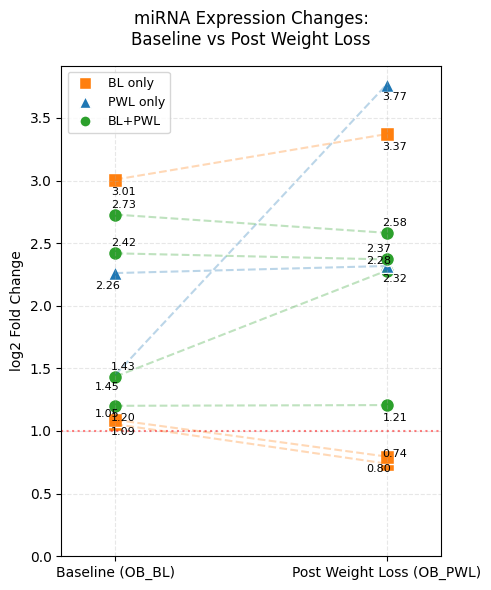

In [50]:
plt.figure(figsize=(5, 6))  # Slightly wider figure

# Color and marker settings
style_map = {
    'Respond': {'color': '#FF7F0E', 'marker': 's', 'label': 'BL only'},
    'Remodelling': {'color': '#1F77B4', 'marker': '^', 'label': 'PWL only'},
    'Persistent': {'color': '#2CA02C', 'marker': 'o', 'label': 'BL+PWL'}
}

# Plot each miRNA
for idx, row in DE_table.iterrows():
    category = row['Type']
    style = style_map[category]
    
    # Plot BL and PWL points with connecting line
    plt.plot([1, 2], 
             [row['log2_fold_change_BL_vs_Lean'], row['log2_fold_change_PWL_vs_Lean']], 
             color=style['color'], 
             alpha=0.3, 
             linestyle='--')
    
    # Plot BL point (for all categories now, including Remodelling)
    plt.scatter(1, row['log2_fold_change_BL_vs_Lean'], 
                color=style['color'], 
                marker=style['marker'], 
                s=100,
                edgecolor='white',
                linewidth=1,
                label=style['label'] if idx in [0,2,5] else "")
    
    # Plot PWL point for all
    plt.scatter(2, row['log2_fold_change_PWL_vs_Lean'], 
                color=style['color'], 
                marker=style['marker'], 
                s=100,
                edgecolor='white',
                linewidth=1)
    
    # Annotate values with adjusted vertical and horizontal positions
    y_offset = 0.08 if idx % 2 else -0.1  # Alternate offset direction
    x_offset1 = -0.03 if idx % 3 == 0 else 0.03  # Slight horizontal offset for BL points
    x_offset2 = -0.03 if idx % 3 == 1 else 0.03  # Slight horizontal offset for PWL points
    
    plt.text(1 + x_offset1, row['log2_fold_change_BL_vs_Lean'] + y_offset, 
             f"{row['log2_fold_change_BL_vs_Lean']:.2f}", 
             ha='center', va='center', fontsize=8)
    plt.text(2 + x_offset2, row['log2_fold_change_PWL_vs_Lean'] + y_offset, 
             f"{row['log2_fold_change_PWL_vs_Lean']:.2f}", 
             ha='center', va='center', fontsize=8)

# Customize the plot
plt.xticks([1, 2], ['Baseline (OB_BL)', 'Post Weight Loss (OB_PWL)'], fontsize=10)
plt.ylabel('log2 Fold Change', fontsize=10)
plt.title('miRNA Expression Changes:\nBaseline vs Post Weight Loss', fontsize=12, pad=15)
plt.grid(True, linestyle='--', alpha=0.3)

plt.ylim(bottom=0)
plt.xlim([0.8, 2.2])  # Adjusted x-limits for better spacing

plt.axhline(y=1, color='red', linestyle=':', alpha=0.5)

# Add legend
handles = []
for category, style in style_map.items():
    handles.append(plt.Line2D([0], [0], 
                         marker=style['marker'], 
                         color='w', 
                         markerfacecolor=style['color'],
                         markersize=8, 
                         label=style['label']))
plt.legend(handles=handles, loc='upper left', fontsize=9)

# Adjust layout
plt.tight_layout()
#plt.savefig('DE_lineplot.pdf', bbox_inches='tight')
plt.show()

##### interpretation of Up/Down Regulation:
<br> >1 : Up regulated in Group1 (Obese)
<br><-1: Down regulated in Group1 (Obese)

maybe not useful:
<br>Except Feature 153, both pvalue change and effect size change are very small, means they are quite persisent to WL
<br> For feature 153, it seems like after WL it normalized (with effect size = 0.18). Again this could be due to by itself it respond to WL, however, it is the interaction (co-expression) of it with other features make it persisent pattern to WL (This is proved in the tsne plot)

# miRNA gene Analysis tools 

##### find if a mirna-gene association is valid
https://dianalab.e-ce.uth.gr/html/dianauniverse/index.php?r=microT_CDS/results&keywords=hsa-miR-30a-5p&genes=&mirnas=hsa-miR-30a-5p%20&descr=&threshold=0.7
##### mirna-mRNA network and enrichment PPI analysis
https://www.mirnet.ca/miRNet/home.xhtml
https://mirdb.org/cgi-bin/search.cgi
##### miRNA disease association databse
http://www.cuilab.cn/hmdd
##### finding associated genomic variation location
https://www.ncbi.nlm.nih.gov/gene/442893
##### GWAS catalogue
https://www.ebi.ac.uk/gwas/variants/rs746839